<a href="https://colab.research.google.com/github/wp900622/StockPrediction/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor,plot_importance, plot_tree
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,KFold
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from ta.momentum import RSIIndicator,StochasticOscillator



In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=c083fb2742f3bb48813e2684054ed45d06770b08cca9099600a9c76ac7a33933
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


[*********************100%%**********************]  1 of 1 completed


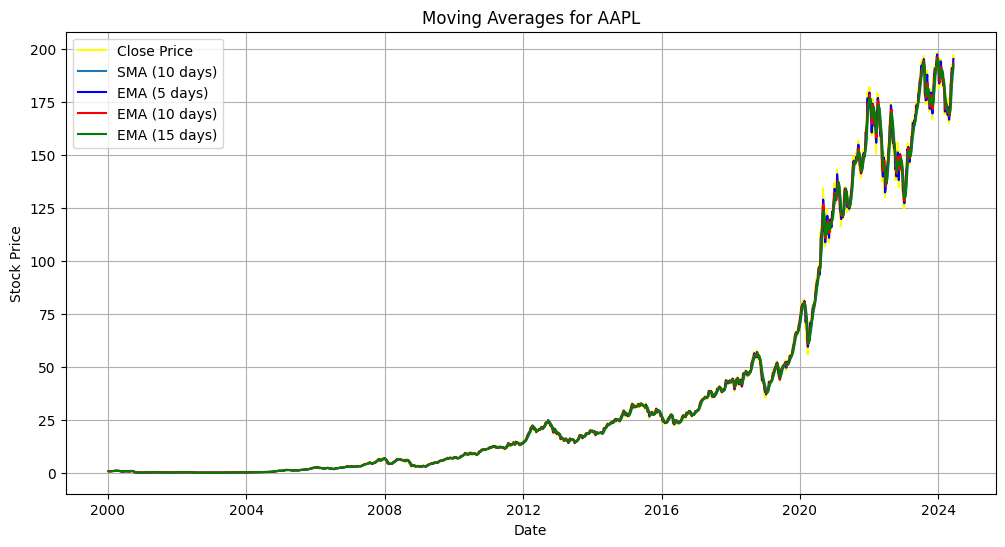

In [ ]:
def calculate_and_plot_moving_averages(data):
  """
  Downloads stock data, calculates simple and exponential moving averages,
  and plots them along with the closing price.

  Args:
      ticker (str): The stock ticker symbol.
      window_size_sma (int): The window size for the simple moving average.
      window_size_ema (int): The window size for the exponential moving average.
  """
  window_size_sma = 10
  # Download stock data

  data.dropna(inplace=True)
  # Calculate simple moving average (SMA)
  closing_price = data['Close']
  volume = data['Volume']
  data['EMA_9'] = data['Close'].ewm(9).mean() # exponential moving average of window 9
  data['5MA'] = data['Close'].rolling(5).mean() # moving average of window 5
  data['10MA'] = data['Close'].rolling(10).mean() # moving average of window 10
  data['15SMA'] = data['Close'].rolling(15).mean() # moving average of window 15
  data['SMA'] = data['Close'].rolling(20).mean() # moving average of window 20
  data['SMA_25'] = data['Close'].rolling(25).mean() # moving average of window 25
  data['3MA'] = data['Close'].rolling(3).mean() # moving average of window 30
  data['30MA'] = data['Close'].rolling(30).mean() # moving average of window 30
  data['365MA'] = data['Close'].rolling(365).mean() # moving average of window 300
  EMA_12 = pd.Series(data['Close'].ewm(span=12, min_periods=12).mean())
  EMA_26 = pd.Series(data['Close'].ewm(span=26, min_periods=26).mean())
  data['MACD'] = pd.Series(EMA_12 - EMA_26)    # calculates Moving Average Convergence Divergence
  data['MACD_signal'] = pd.Series(data.MACD.ewm(span=9, min_periods=9).mean())
  data['RSI'] = RSIIndicator(data['Close']).rsi() # calculates Relative Strength Index
  data['Stochastic']=StochasticOscillator(data['High'],data['Low'],data['Close']).stoch()
  data['yoy'] = (data['Close'] - data['Close'].shift(252)) / data['Close'].shift(252) * 100
  data.index = pd.to_datetime(data.index)
  data['Is_month_end'] = data.index.is_month_end.astype(int)
  data['Is_month_start'] = data.index.is_month_start.astype(int)
  data['Is_quarter_end'] = data.index.is_quarter_end.astype(int)
  data['Is_quarter_start'] = data.index.is_quarter_start.astype(int)
  data['Is_year_end'] = data.index.is_year_end.astype(int)
  data['Is_year_start'] = data.index.is_year_start.astype(int)
  data['5volume'] = data['Volume'].rolling(5).mean() # moving average of window 5
  data['10volume'] = data['Volume'].rolling(10).mean() # moving average of window 5
  data['3volume'] = data['Volume'].rolling(3).mean() # moving average of window 5
  data['price_change'] = data['Close'] - data['Open']
  data['price_change_pct'] = data['price_change'] / data['Open']
  data['volume_pct'] = data['Volume'].pct_change()

  # Calculate percentage change (handle potential division by zero)
  pct_change = closing_price.pct_change() * 100
  pct_change[0] = 0
  labels = pd.DataFrame({'trend':pct_change})
  # Plot closing price, SMA, and EMA
  plt.figure(figsize=(12, 6))
  plt.plot(data.index, data['Close'], label='Close Price',c='yellow')
  plt.plot(data.index, data['SMA'], label=f'SMA ({window_size_sma} days)')
  plt.plot(data.index, data['5MA'], label=f'EMA (5 days)',c='blue')
  plt.plot(data.index, data['10MA'], label=f'EMA (10 days)',c='red')
  plt.plot(data.index, data['15SMA'], label=f'EMA (15 days)',c='green')
  plt.xlabel('Date')
  plt.ylabel('Stock Price')
  plt.title(f'Moving Averages for {ticker}')
  plt.legend()
  plt.grid(True)
  plt.show()
  return data,labels

# Example usage
ticker = 'AAPL'  # Replace with your desired stock ticker
data = yf.download(ticker,start="2000-1-1")

moving_average, trend = calculate_and_plot_moving_averages(data)




In [ ]:
moving_average

Open        High         Low       Close   Adj Close  \
Date                                                                     
2000-01-03    0.936384    1.004464    0.907924    0.999442    0.844981   
2000-01-04    0.966518    0.987723    0.903460    0.915179    0.773740   
2000-01-05    0.926339    0.987165    0.919643    0.928571    0.785063   
2000-01-06    0.947545    0.955357    0.848214    0.848214    0.717125   
2000-01-07    0.861607    0.901786    0.852679    0.888393    0.751094   
...                ...         ...         ...         ...         ...   
2024-06-03  192.899994  194.990005  192.520004  194.029999  194.029999   
2024-06-04  194.639999  195.320007  193.029999  194.350006  194.350006   
2024-06-05  195.399994  196.899994  194.869995  195.869995  195.869995   
2024-06-06  195.690002  196.500000  194.169998  194.479996  194.479996   
2024-06-07  194.649994  196.940002  194.139999  196.889999  196.889999   

               Volume       EMA_9         5MA        10MA       15SMA  ...  \
Date                                                                   ...   
2000-01-03  535796800    0.999442         NaN         NaN         NaN  ...   
2000-01-04  512377600    0.955093         NaN         NaN         NaN  ...   
2000-01-05  778321600    0.945306         NaN         NaN         NaN  ...   
2000-01-06  767972800    0.917074         NaN         NaN         NaN  ...   
2000-01-07  460734400    0.910070    0.915960         NaN         NaN  ...   
...               ...         ...         ...         ...         ...  ...   
2024-06-03   50080500  187.747070  191.569998  190.899998  190.142665  ...   
2024-06-04   47471400  188.407364  192.441998  191.231000  190.680665  ...   
2024-06-05   54156800  189.153627  193.557999  191.582999  191.243332  ...   
2024-06-06   41181800  189.686264  194.195999  191.940999  191.560665  ...   
2024-06-07   53044700  190.406637  195.123999  192.941998  192.030665  ...   

            Is_month_start  Is_quarter_end  Is_quarter_start  Is_year_end  \
Date                                                                        
2000-01-03               0               0                 0            0   
2000-01-04               0               0                 0            0   
2000-01-05               0               0                 0            0   
2000-01-06               0               0                 0            0   
2000-01-07               0               0                 0            0   
...                    ...             ...               ...          ...   
2024-06-03               0               0                 0            0   
2024-06-04               0               0                 0            0   
2024-06-05               0               0                 0            0   
2024-06-06               0               0                 0            0   
2024-06-07               0               0                 0            0   

            Is_year_start      5volume    10volume       3volume  \
Date                                                               
2000-01-03              0          NaN         NaN           NaN   
2000-01-04              0          NaN         NaN           NaN   
2000-01-05              0          NaN         NaN  6.088320e+08   
2000-01-06              0          NaN         NaN  6.862240e+08   
2000-01-07              0  611040640.0         NaN  6.690096e+08   
...                   ...          ...         ...           ...   
2024-06-03              0   56106960.0  48915450.0  5.839557e+07   
2024-06-04              0   55145220.0  49226460.0  5.757007e+07   
2024-06-05              0   55362980.0  50411200.0  5.056957e+07   
2024-06-06              0   53609760.0  51064530.0  4.760333e+07   
2024-06-07              0   49187040.0  51268410.0  4.946110e+07   

            price_change  price_change_pct  
Date                                        
2000-01-03      0.063058          0.067342  
2000-01-04     -0.

In [ ]:
def labelencode(share):
  LE=LabelEncoder()
  share['Is_month_end']=LE.fit_transform(share['Is_month_end'])
  share['Is_month_start']=LE.fit_transform(share['Is_month_start'])
  share['Is_quarter_end']=LE.fit_transform(share['Is_quarter_end'])
  share['Is_quarter_start']=LE.fit_transform(share['Is_quarter_start'])
  share['Is_year_end']=LE.fit_transform(share['Is_year_end'])
  share['Is_year_start']=LE.fit_transform(share['Is_year_start'])

In [ ]:
labelencode(moving_average)

In [ ]:
trend

trend
Date                
2000-01-03  0.000000
2000-01-04 -8.431001
2000-01-05  1.463317
2000-01-06 -8.653837
2000-01-07  4.736896
...              ...
2024-06-03  0.925877
2024-06-04  0.164927
2024-06-05  0.782088
2024-06-06 -0.709654
2024-06-07  1.239204

[6147 rows x 1 columns]

In [ ]:
moving_average

Open        High         Low       Close   Adj Close  \
Date                                                                     
2000-01-03    0.936384    1.004464    0.907924    0.999442    0.844981   
2000-01-04    0.966518    0.987723    0.903460    0.915179    0.773741   
2000-01-05    0.926339    0.987165    0.919643    0.928571    0.785063   
2000-01-06    0.947545    0.955357    0.848214    0.848214    0.717125   
2000-01-07    0.861607    0.901786    0.852679    0.888393    0.751094   
...                ...         ...         ...         ...         ...   
2024-06-03  192.899994  194.990005  192.520004  194.029999  194.029999   
2024-06-04  194.639999  195.320007  193.029999  194.350006  194.350006   
2024-06-05  195.399994  196.899994  194.869995  195.869995  195.869995   
2024-06-06  195.690002  196.500000  194.169998  194.479996  194.479996   
2024-06-07  194.649994  196.940002  194.139999  196.889999  196.889999   

               Volume       EMA_9         5MA        10MA       15SMA  ...  \
Date                                                                   ...   
2000-01-03  535796800    0.999442         NaN         NaN         NaN  ...   
2000-01-04  512377600    0.955093         NaN         NaN         NaN  ...   
2000-01-05  778321600    0.945306         NaN         NaN         NaN  ...   
2000-01-06  767972800    0.917074         NaN         NaN         NaN  ...   
2000-01-07  460734400    0.910070    0.915960         NaN         NaN  ...   
...               ...         ...         ...         ...         ...  ...   
2024-06-03   50080500  187.747070  191.569998  190.899998  190.142665  ...   
2024-06-04   47471400  188.407364  192.441998  191.231000  190.680665  ...   
2024-06-05   54156800  189.153627  193.557999  191.582999  191.243332  ...   
2024-06-06   41181800  189.686264  194.195999  191.940999  191.560665  ...   
2024-06-07   53044700  190.406637  195.123999  192.941998  192.030665  ...   

            Is_quarter_end  Is_quarter_start  Is_year_end  Is_year_start  \
Date                                                                       
2000-01-03               0                 0            0              0   
2000-01-04               0                 0            0              0   
2000-01-05               0                 0            0              0   
2000-01-06               0                 0            0              0   
2000-01-07               0                 0            0              0   
...                    ...               ...          ...            ...   
2024-06-03               0                 0            0              0   
2024-06-04               0                 0            0              0   
2024-06-05               0                 0            0              0   
2024-06-06               0                 0            0              0   
2024-06-07               0                 0            0              0   

                5volume    10volume       3volume  price_change  \
Date                                                              
2000-01-03          NaN         NaN           NaN      0.063058   
2000-01-04          NaN         NaN           NaN     -0.051339   
2000-01-05          NaN         NaN  6.088320e+08      0.002232   
2000-01-06          NaN         NaN  6.862240e+08     -0.099331   
2000-01-07  611040640.0         NaN  6.690096e+08      0.026786   
...                 ...         ...           ...           ...   
2024-06-03   56106960.0  48915450.0  5.839557e+07      1.130005   
2024-06-04   55145220.0  49226460.0  5.757007e+07     -0.289993   
2024-06-05   55362980.0  50411200.0  5.056957e+07      0.470001   
2024-06-06   53609760.0  51064530.0  4.760333e+07     -1.210007   
2024-06-07   49187040.0  51268410.0  4.946110e+07      2.240005   

            price_change_pct  volume_pct  
Date                                      
2000-01-03          0.067342         NaN  
2000-01-04         -0.053117   -0.043709  
2000-01

In [ ]:
min_max_scaler = StandardScaler()
moving_average = min_max_scaler.fit_transform(moving_average)
moving_average

array([[-0.6932507 , -0.69222404, -0.6933401 , ...,  0.04159571,
         3.35297063,         nan],
       [-0.69269356, -0.69253031, -0.69342345, ..., -0.08030172,
        -2.68199642, -0.24028286],
       [-0.69343642, -0.69254052, -0.69312126, ..., -0.02321832,
         0.09988049,  0.97959077],
       ...,
       [ 2.90213372,  2.89159177,  2.92855663, ...,  0.47522045,
         0.09967144,  0.15974412],
       [ 2.90749561,  2.88427407,  2.91548543, ..., -1.3149382 ,
        -0.33061441, -0.66487827],
       [ 2.88826718,  2.89232371,  2.91492526, ...,  2.36127609,
         0.55570459,  0.47889933]])

In [ ]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(len(moving_average) * (1-test_size))
valid_split_idx = int(len(moving_average) * (1-(valid_size+test_size)))

X_train  = moving_average[:valid_split_idx].copy()
X_valid  = moving_average[valid_split_idx+1:test_split_idx].copy()
X_test   = moving_average[test_split_idx+1:].copy()

In [ ]:
X_train.shape

(4302, 32)

In [ ]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(len(trend) * (1-test_size))
valid_split_idx = int(len(trend) * (1-(valid_size+test_size)))

y_train  = trend[:valid_split_idx].copy().values.reshape(-1, trend.shape[1])
y_valid  = trend[valid_split_idx+1:test_split_idx].copy().values.reshape(-1, trend.shape[1])
y_test   = trend[test_split_idx+1:].copy().values.reshape(-1, trend.shape[1])

In [ ]:
y_train = y_train.reshape(-1)
y_valid = y_valid.reshape(-1)
y_test = y_test.reshape(-1)

In [ ]:
y_train.shape

(4302, 1)

In [ ]:
params = {
    'n_estimators': [500,600],
    'learning_rate': [0.01],
    'max_depth': [8, 12, 15],
    'gamma': [ 0.005, 0.01,],
    'random_state': [42],
    'min_child_weight':[4,3],
    'subsample':[0.8,1],
    'colsample_bytree':[1],
    'colsample_bylevel':[1]
}
eval_set = [(X_train, y_train), (X_valid, y_valid)]
kfold=KFold(2)


model = XGBRegressor(objective='reg:squarederror',n_jobs=-1)
clf = GridSearchCV(model, params,cv=kfold,scoring='neg_mean_absolute_error',verbose=2)

clf.fit(X_train, y_train)



print(f'Best test score = {clf.best_score_}')

Fitting 2 folds for each of 48 candidates, totalling 96 fits


KeyboardInterrupt: 

In [ ]:

params={'colsample_bylevel': 1,
 'colsample_bytree': 0.85,
 'gamma': 0.30,
 'learning_rate': 0.01,
 'max_depth': 90,
 'min_child_weight': 150,
 'n_estimators': 1200,
 'random_state': 42,
 'subsample': 0.6}
eval_set = [(X_train, y_train), (X_valid, y_valid)]

xgb=XGBRegressor(**params, objective='reg:squarederror',n_jobs=-1)
xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)
y_pred = xgb.predict(X_test)
mean_squared_error(y_test, y_pred)
xgb.score(X_test,y_test)

0.7081250501571239

ValueError: continuous is not supported

In [ ]:
y_test[-10:]


array([ 1.65881355,  0.00526885,  0.15789662,  0.52551371,  0.50185935,
        0.92587713,  0.16492673,  0.78208848, -0.70965407,  1.23920388])

In [ ]:
y_test= y_test.reshape(-1)
y_pred[-10:]

array([ 0.39157605, -0.47450656,  0.21066256,  0.18570678,  0.8898222 ,
        0.3530929 ,  0.03231322,  0.403435  , -0.46050355,  1.197139  ],
      dtype=float32)

In [ ]:
# prompt: 把y_pred轉換成股價

import pandas as pd
import numpy as np
def predict_stock_price(y_pred, data):
  """
  Converts the predicted percentage change back to stock price.

  Args:
      y_pred (np.ndarray): The predicted percentage change.
      moving_average (pd.DataFrame): The moving average data.

  Returns:
      np.ndarray: The predicted stock price.
  """
  last_price = data['Close'][len(y_test)*(-1)]
  predicted_price = []
  for i in range(len(y_pred)):
    predicted_price.append(last_price * (1 + y_pred[i]/100))
    last_price = predicted_price[-1]

  return np.array(predicted_price)

predicted_stock_price = predict_stock_price(y_pred, data)
test_stock_price = predict_stock_price(y_test, data)
predicted_stock_price
predicted_stock_price[-922]

y_pred

array([-8.03139865e-01,  1.33254230e+00,  4.57030725e+00, -3.70795703e+00,
        3.90317023e-01,  1.51955700e+00, -1.38064027e+00, -3.77616334e+00,
        6.51485026e-01,  1.95451930e-01, -1.58508933e+00, -1.00286937e+00,
        9.34850946e-02,  6.76568627e-01, -4.58236265e+00,  2.34258342e+00,
       -1.91310501e+00,  1.06541321e-01,  1.00351655e+00,  1.23674297e+00,
        1.40164840e+00,  8.11391294e-01, -3.52617550e+00,  3.02713513e-01,
        1.58462095e+00, -3.10357511e-01, -1.16826661e-01,  9.91423249e-01,
       -6.62267879e-02, -5.57197630e-01,  7.02939749e-01, -1.08331084e+00,
       -3.21135759e+00,  6.13719344e-01,  3.56334239e-01,  1.74218938e-01,
        1.74752915e+00,  1.16502976e+00,  9.26063061e-01,  4.65648621e-02,
        6.91513494e-02,  1.04295325e+00,  3.13751191e-01, -1.92897213e+00,
        2.06962705e+00, -1.38453290e-01, -5.27134299e-01,  3.15455031e+00,
        5.20792484e-01,  2.46277943e-01, -1.14890110e+00,  2.33946061e+00,
        6.93728685e-01, -

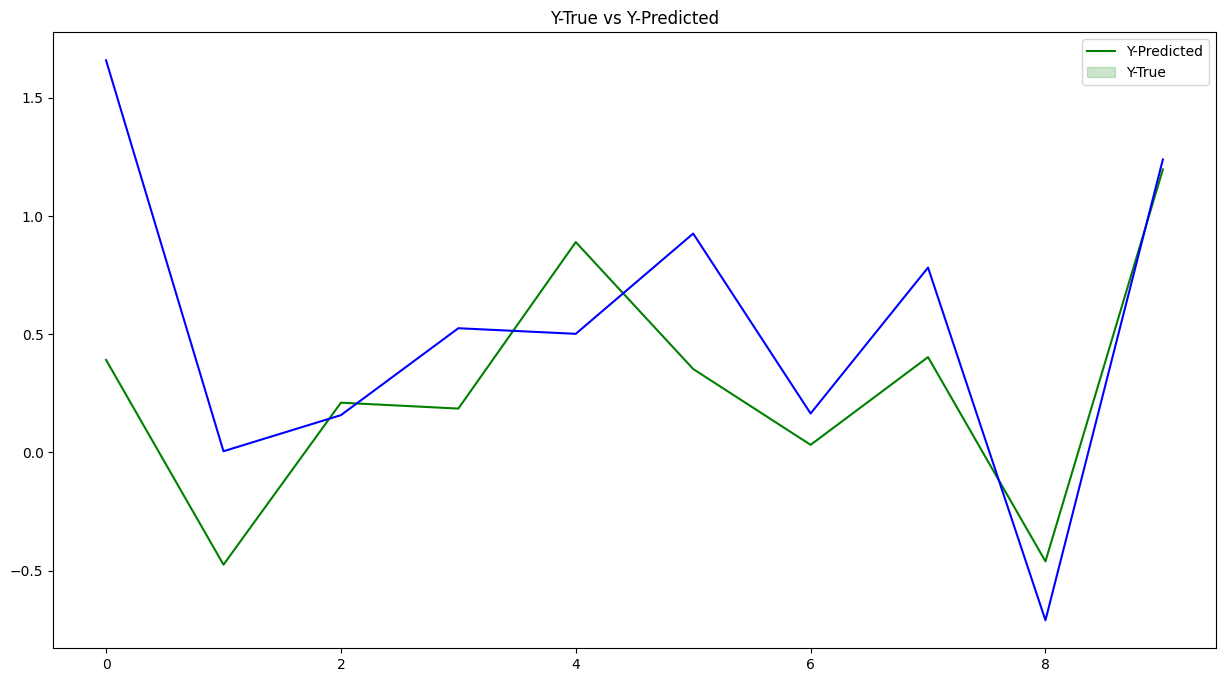

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(y=y_pred[-10:],x=np.arange(10),c='green')
sns.lineplot(y=y_test[-10:],x=np.arange(10),c='blue')
plt.legend(['Y-Predicted','Y-True'])
plt.title('Y-True vs Y-Predicted')
plt.show()

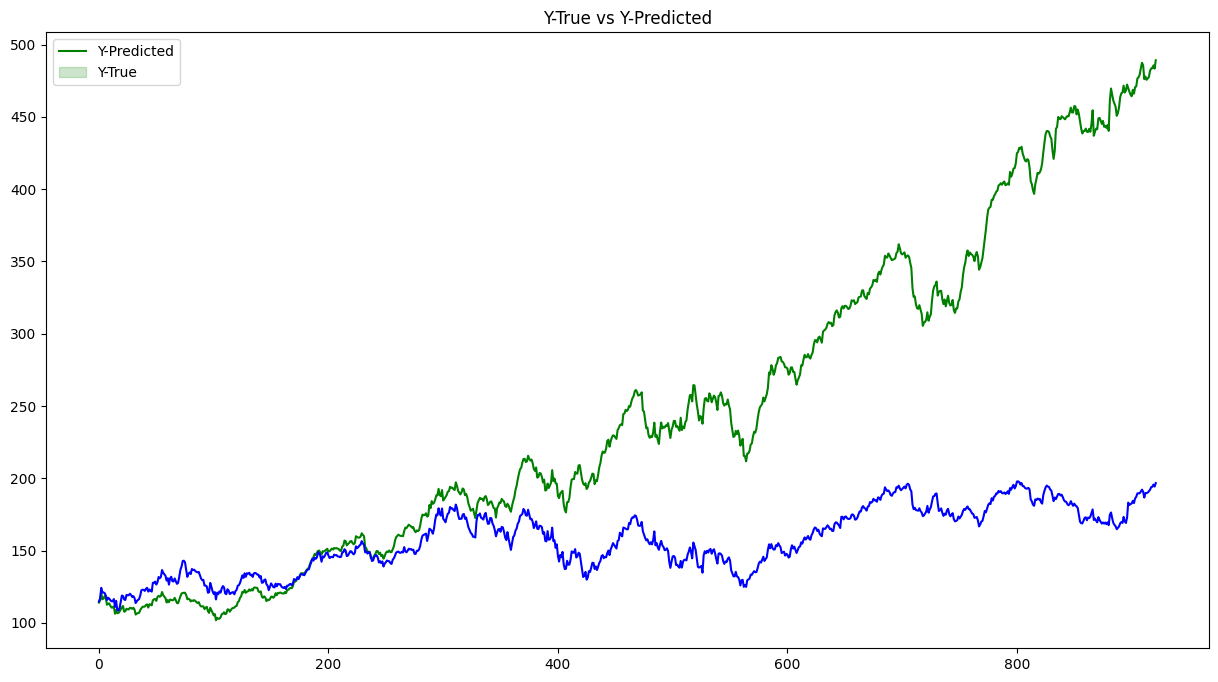

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(y=predicted_stock_price,x=np.arange(922),c='green')
sns.lineplot(y=test_stock_price,x=np.arange(922),c='blue')
plt.legend(['Y-Predicted','Y-True'])
plt.title('Y-True vs Y-Predicted')
plt.show()

In [ ]:
# prompt: save xgb model to predict 30 stock market

import pickle

# Save the model to a file
with open('model.pkl', 'wb') as f:
  pickle.dump(xgb, f)

# Load the model from the file
with open('model.pkl', 'rb') as f:
  loaded_model = pickle.load(f)

# Use the loaded model to predict the stock market
y_pred = loaded_model.predict(X_test)

y_pred

array([-8.03139865e-01,  1.33254230e+00,  4.57030725e+00, -3.70795703e+00,
        3.90317023e-01,  1.51955700e+00, -1.38064027e+00, -3.77616334e+00,
        6.51485026e-01,  1.95451930e-01, -1.58508933e+00, -1.00286937e+00,
        9.34850946e-02,  6.76568627e-01, -4.58236265e+00,  2.34258342e+00,
       -1.91310501e+00,  1.06541321e-01,  1.00351655e+00,  1.23674297e+00,
        1.40164840e+00,  8.11391294e-01, -3.52617550e+00,  3.02713513e-01,
        1.58462095e+00, -3.10357511e-01, -1.16826661e-01,  9.91423249e-01,
       -6.62267879e-02, -5.57197630e-01,  7.02939749e-01, -1.08331084e+00,
       -3.21135759e+00,  6.13719344e-01,  3.56334239e-01,  1.74218938e-01,
        1.74752915e+00,  1.16502976e+00,  9.26063061e-01,  4.65648621e-02,
        6.91513494e-02,  1.04295325e+00,  3.13751191e-01, -1.92897213e+00,
        2.06962705e+00, -1.38453290e-01, -5.27134299e-01,  3.15455031e+00,
        5.20792484e-01,  2.46277943e-01, -1.14890110e+00,  2.33946061e+00,
        6.93728685e-01, -

[*********************100%%**********************]  1 of 1 completed


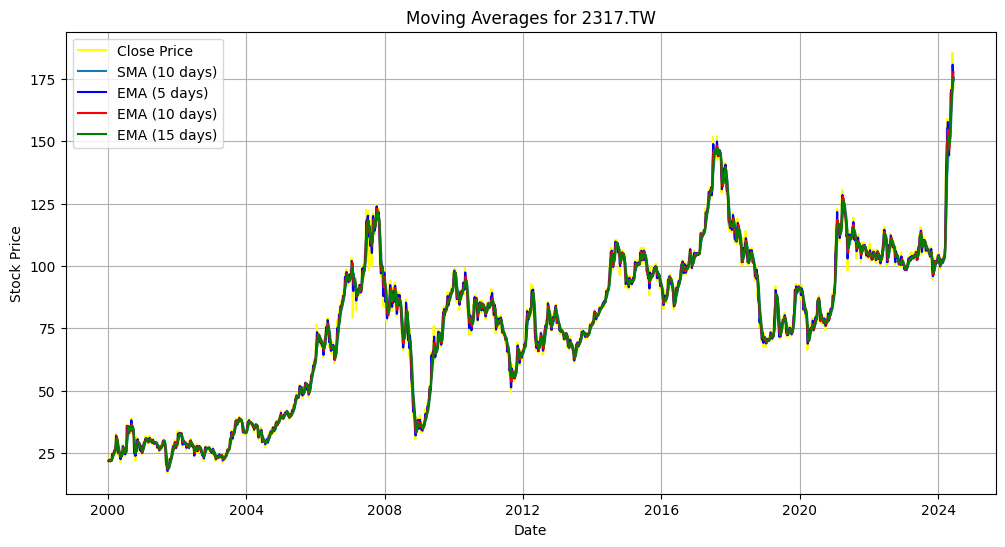

In [ ]:
ticker = '2317.TW'  # Replace with your desired stock ticker



In [ ]:
# prompt: 產生30個台股股票的股票代碼

import pandas as pd
import random

# Get a list of all TWSE stocks
stocks = pd.read_html('https://isin.twse.com.tw/isin/C_public.jsp?strMode=2',encoding='big-5')[0]
stocks.columns = stocks.iloc[0]
stocks.dropna(inplace=True,axis=1)
#stocks.drop(['備註'], inplace=True,axis=1)

#twse_stocks = stocks[stocks['市場別'].str.contains('上市')]['有價證券代號及名稱'].tolist()

# Generate 30 random stock codes
#random_stocks = random.sample(twse_stocks, 30)

# Print the random stock codes
#print(random_stocks)
stocks = stocks[1:30]
stocks.iloc[:,0].tolist()
code = []
name = []
for i in range(1, len(stocks)):
  code.append(stocks.iloc[i,0].split('\u3000')[0]+".TW")
  name.append(stocks.iloc[i,0].split('\u3000')[1])

code[0]

'1101.TW'

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

1101.TW


[*********************100%%**********************]  1 of 1 completed


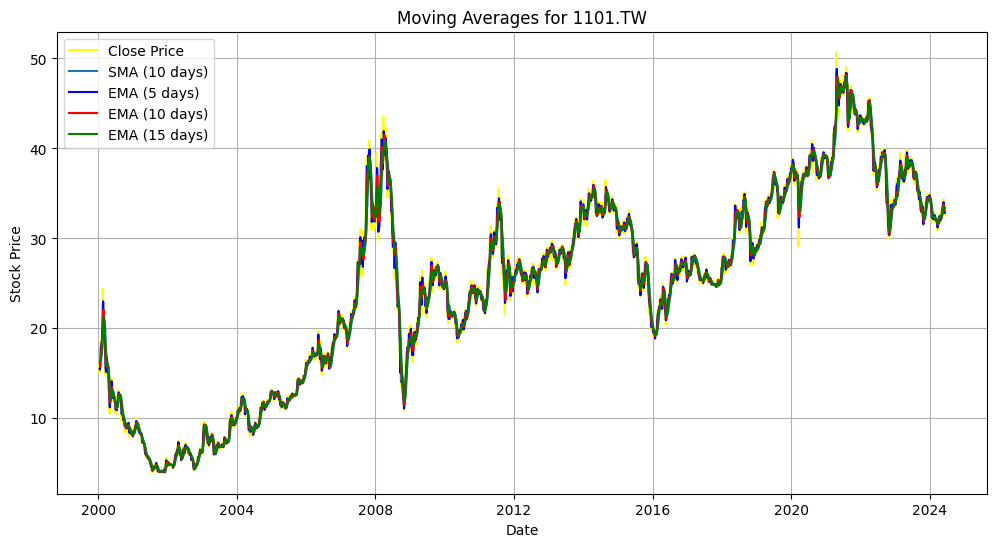

台泥


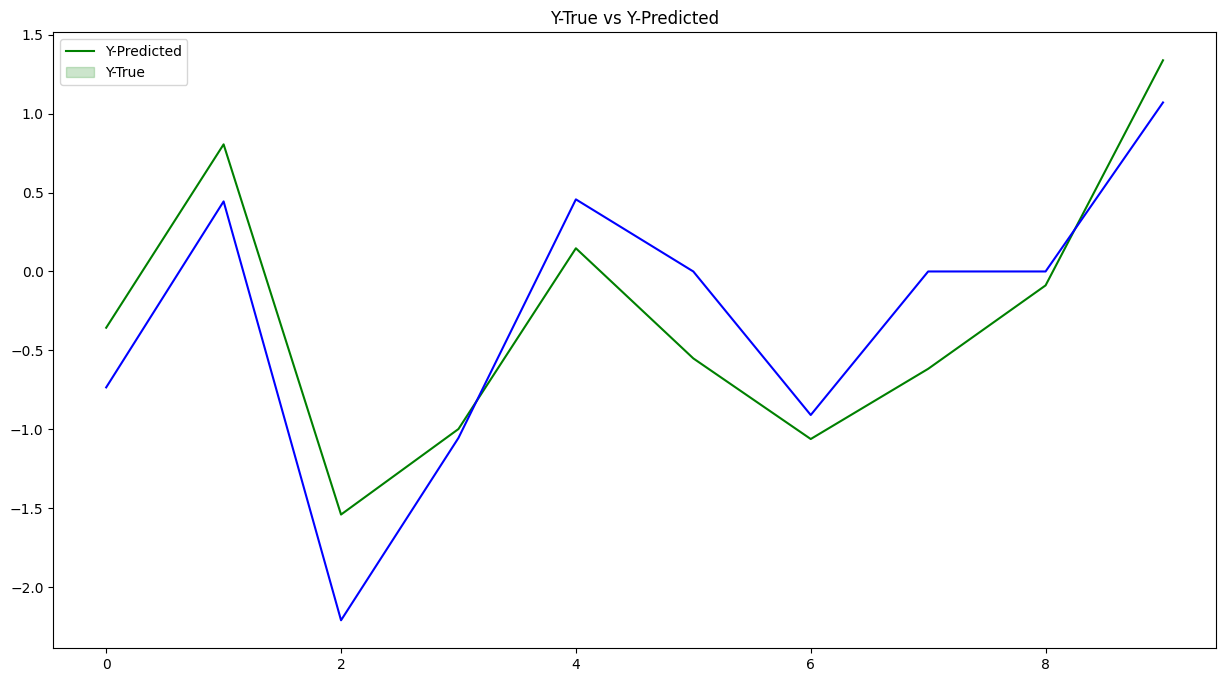

1102.TW


[*********************100%%**********************]  1 of 1 completed


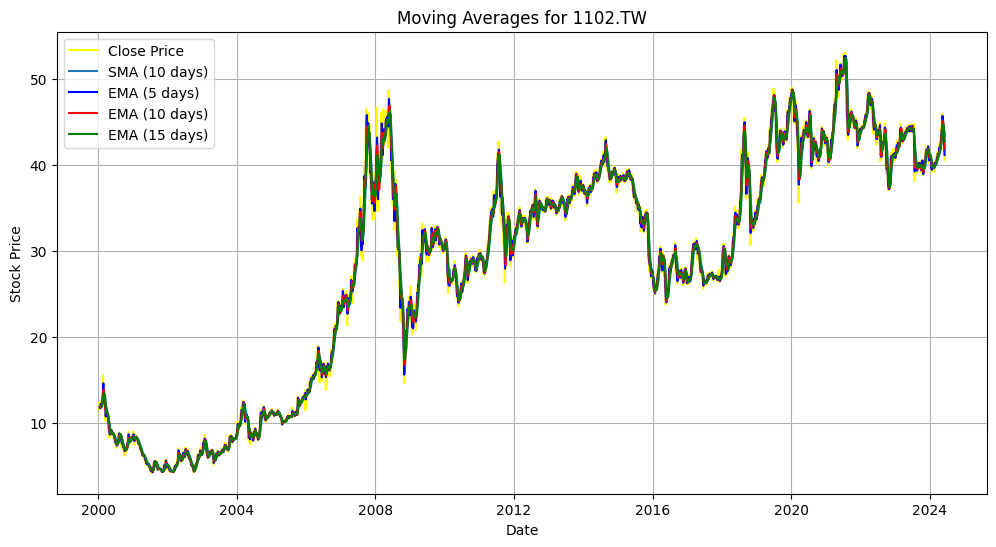

亞泥


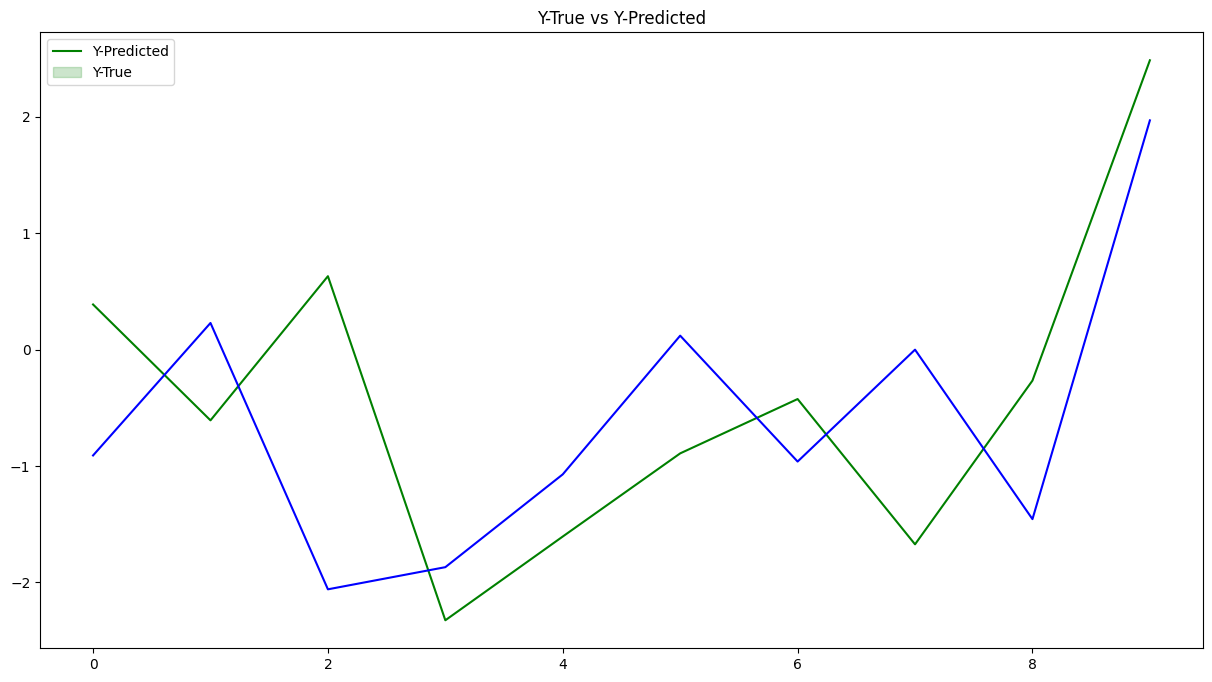

1103.TW


[*********************100%%**********************]  1 of 1 completed


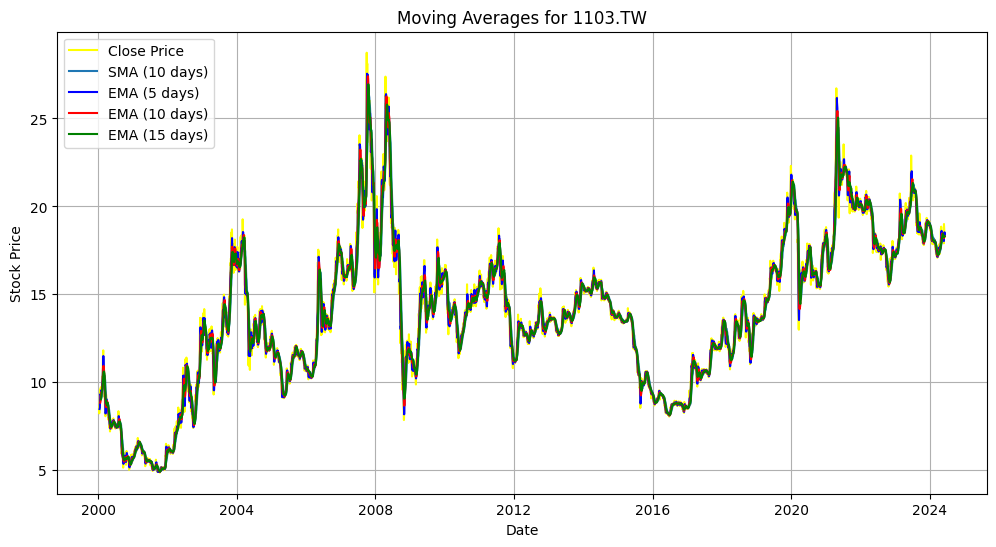

嘉泥


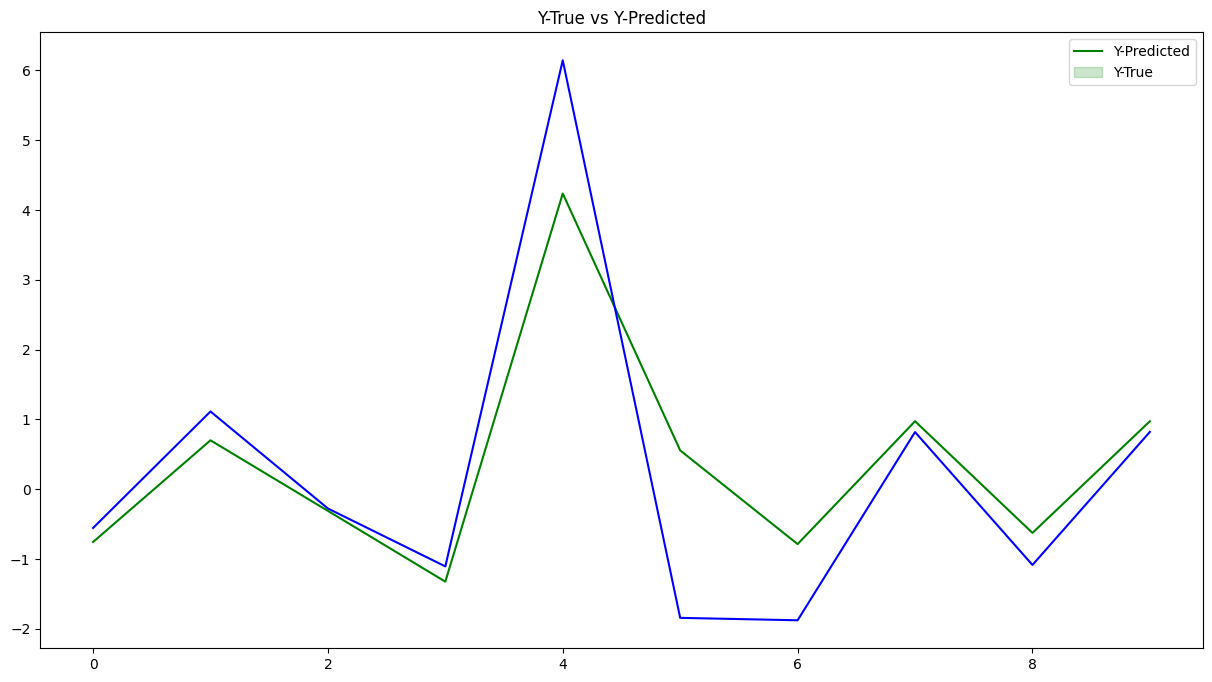

1104.TW


[*********************100%%**********************]  1 of 1 completed


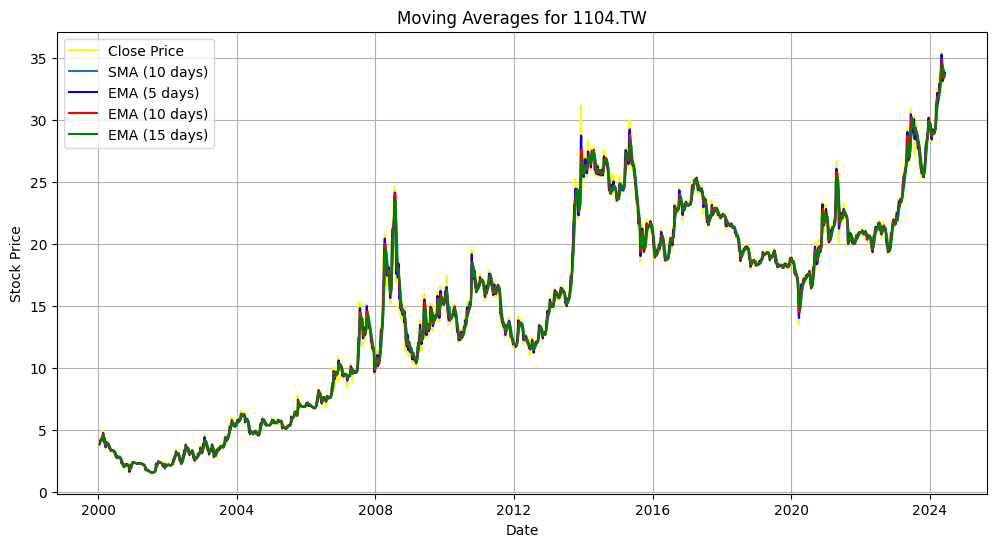

環泥


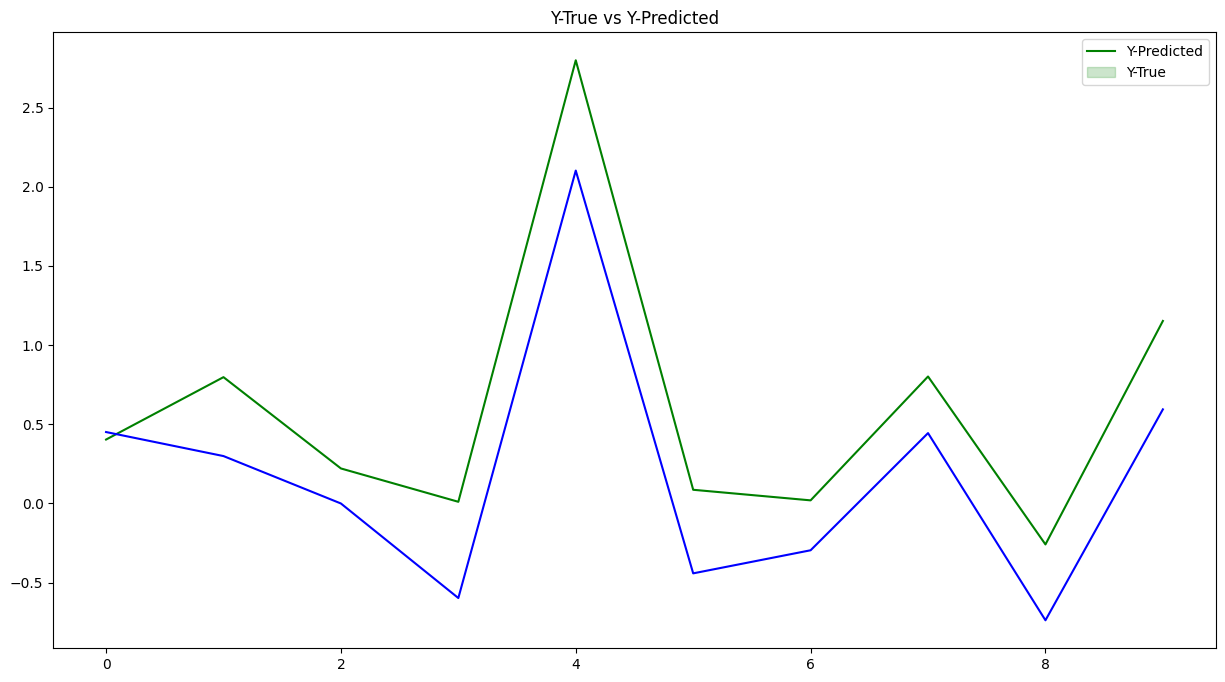

1108.TW


[*********************100%%**********************]  1 of 1 completed


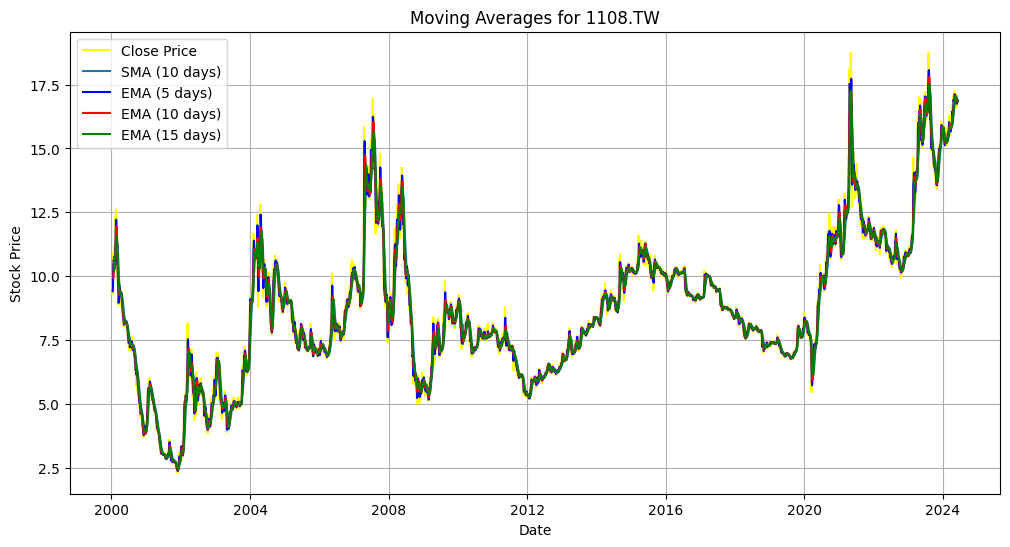

幸福


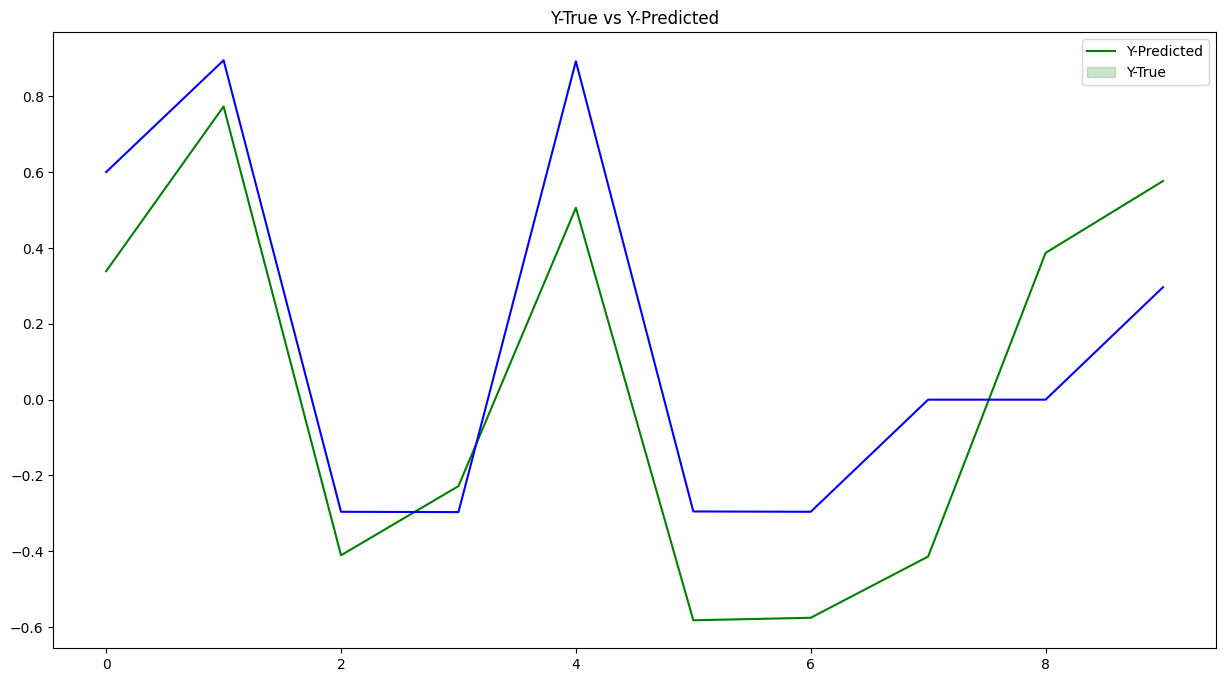

1109.TW


[*********************100%%**********************]  1 of 1 completed


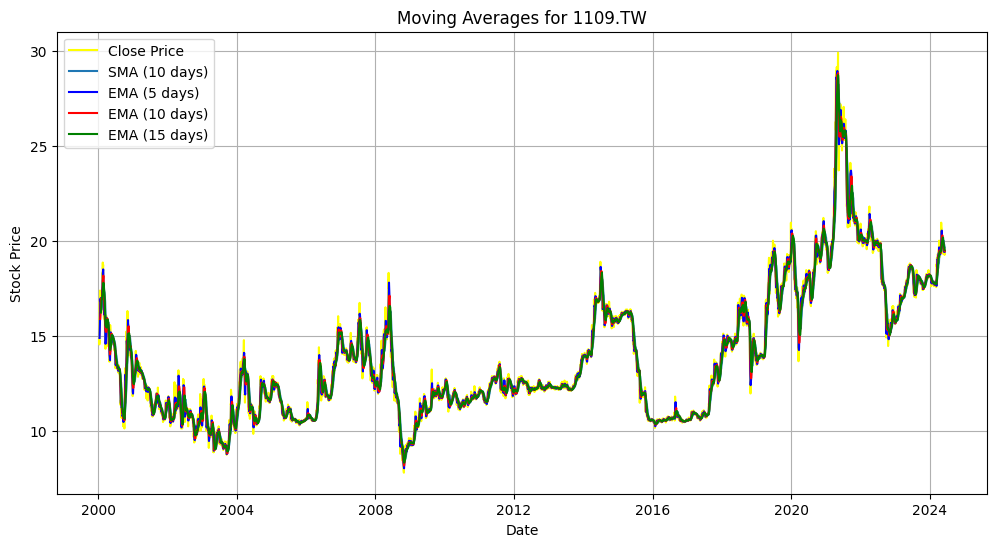

信大


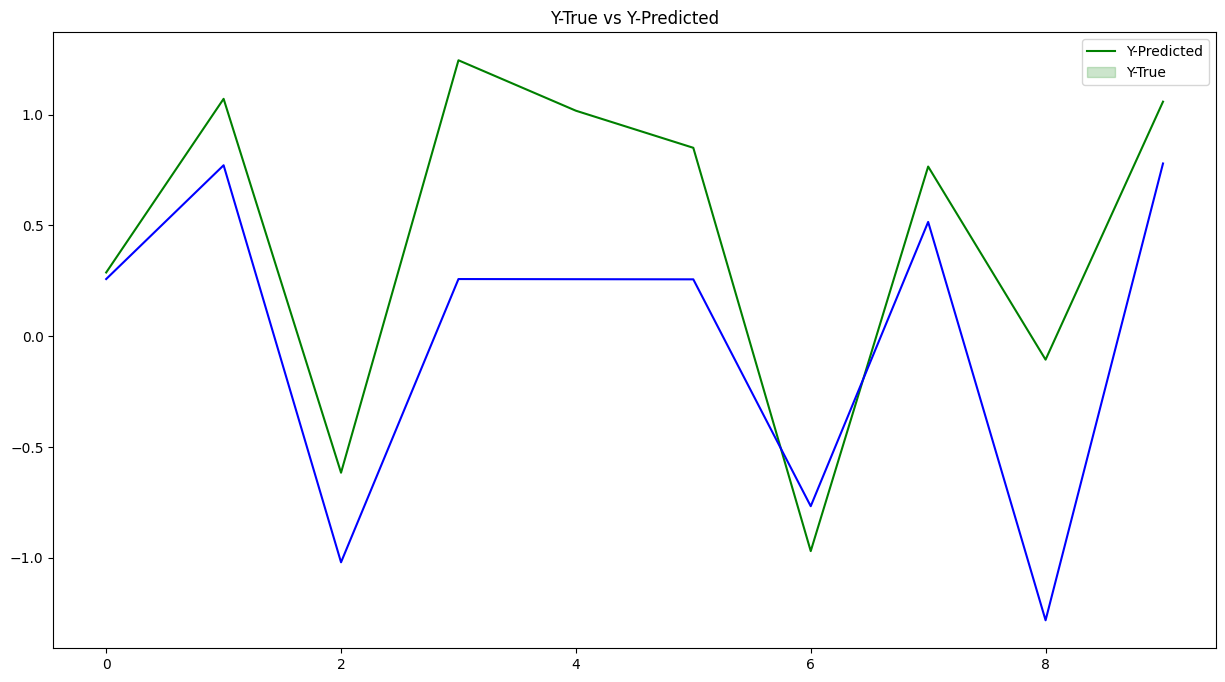

1110.TW


[*********************100%%**********************]  1 of 1 completed


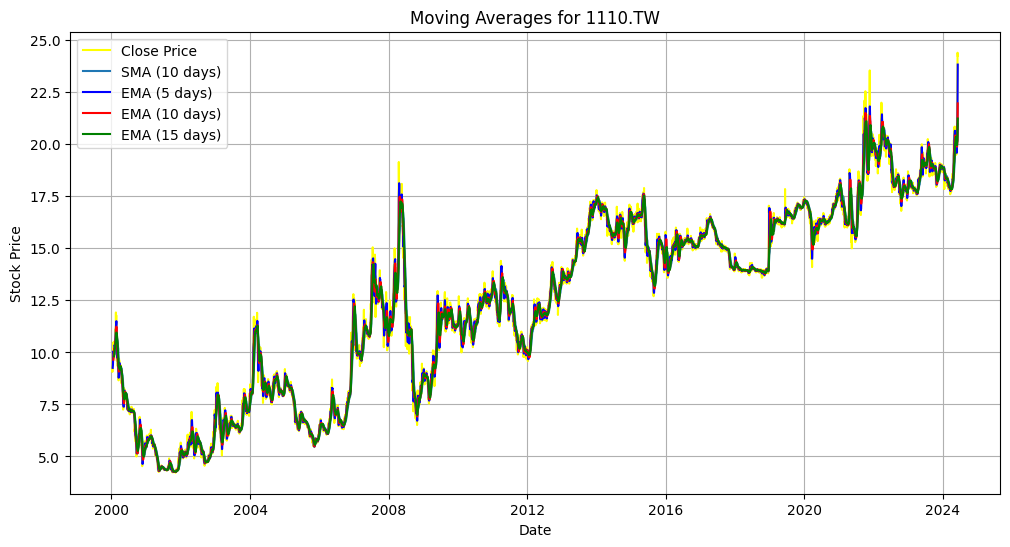

東泥


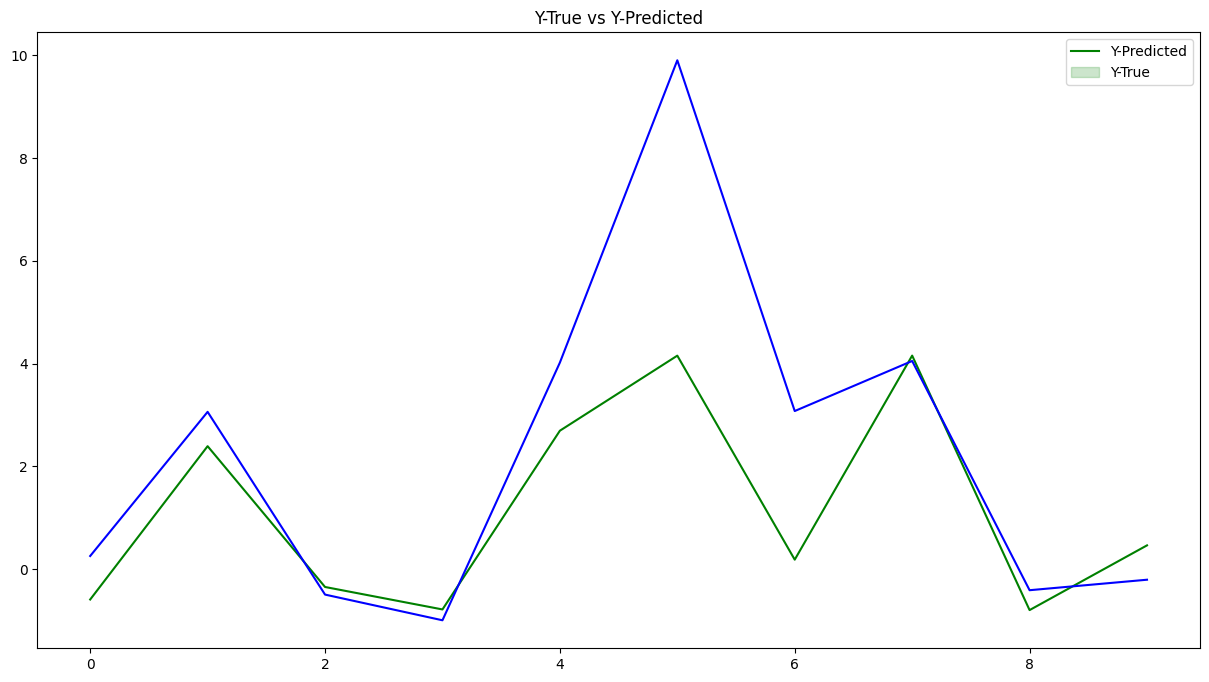

[*********************100%%**********************]  1 of 1 completed

1201.TW


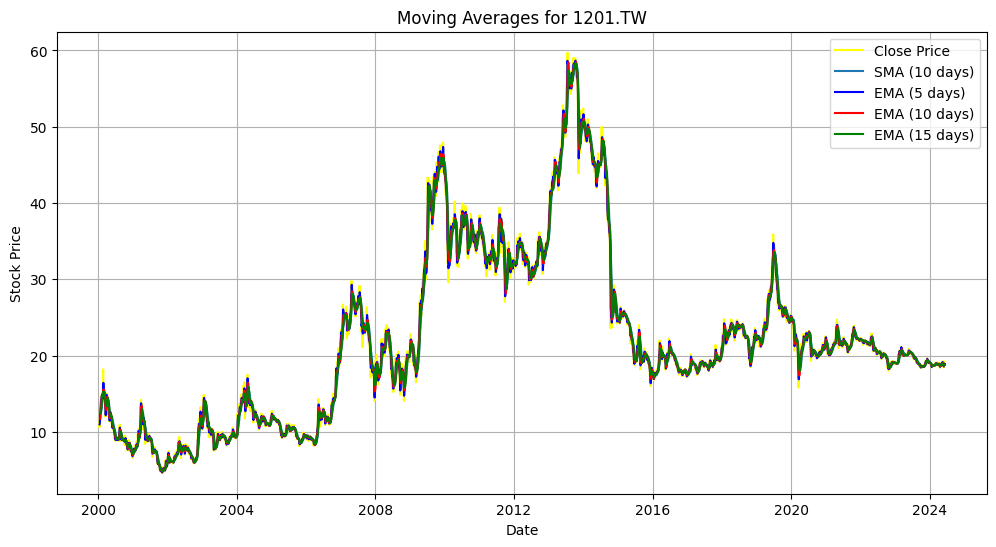

味全


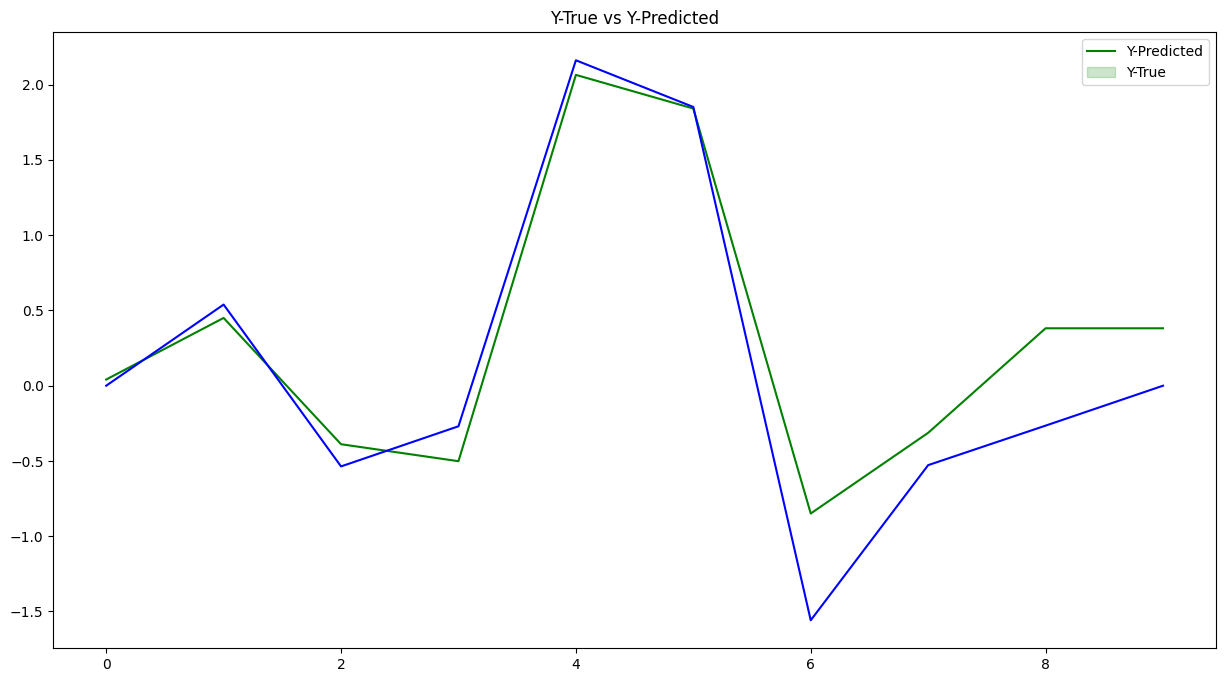

[*********************100%%**********************]  1 of 1 completed

1203.TW


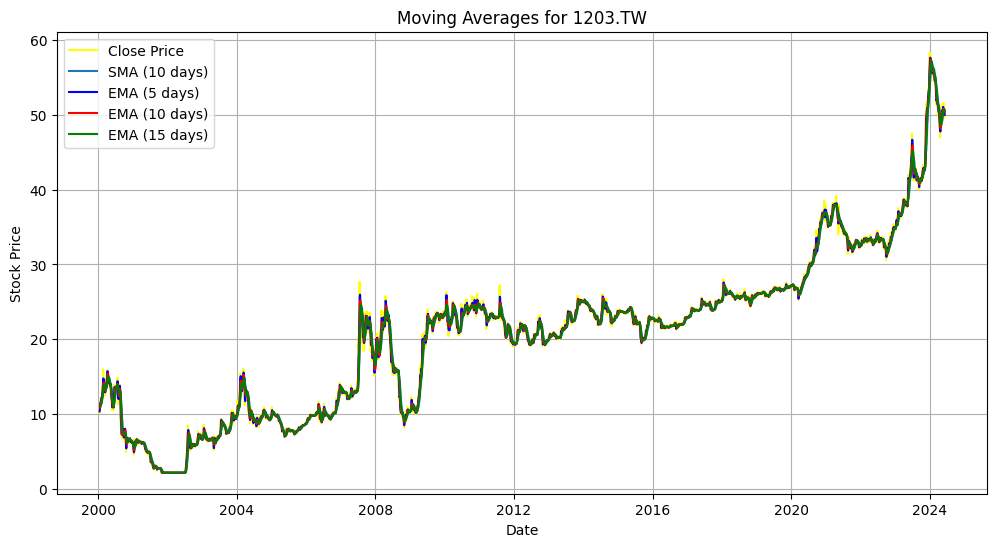

味王


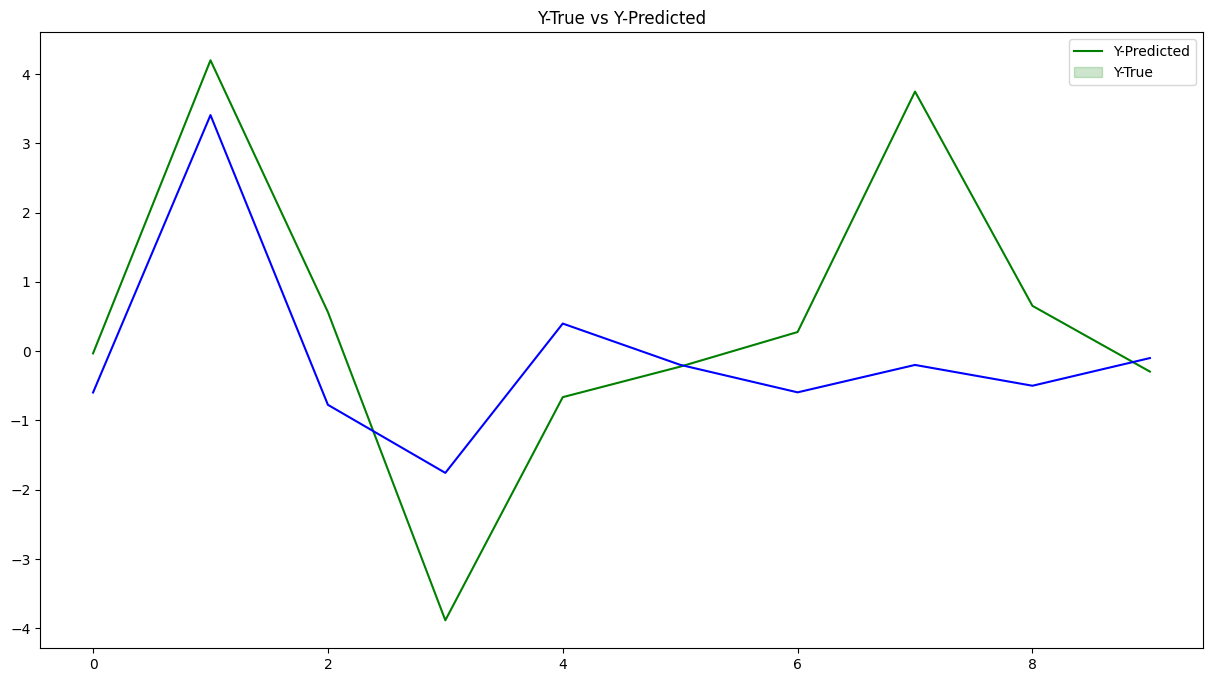

1210.TW


[*********************100%%**********************]  1 of 1 completed


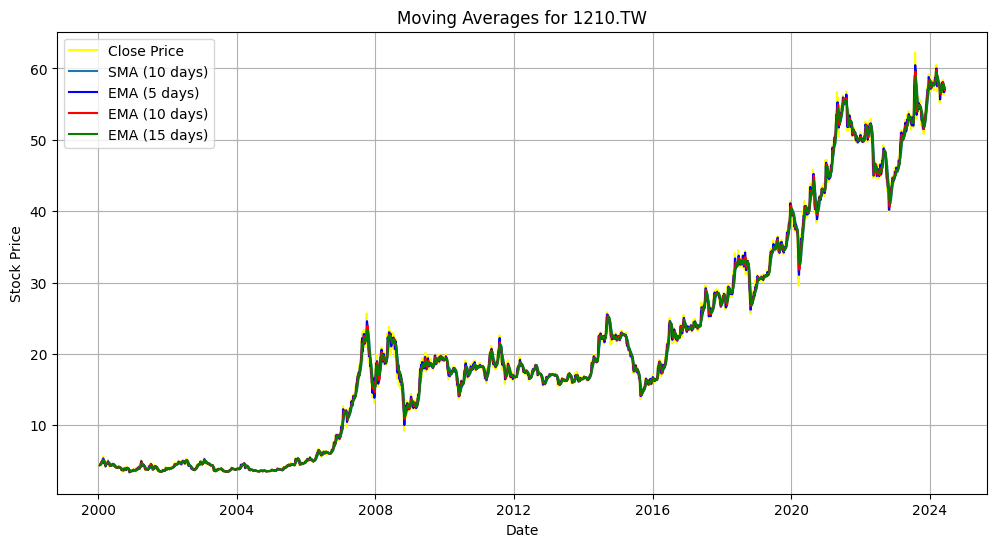

大成


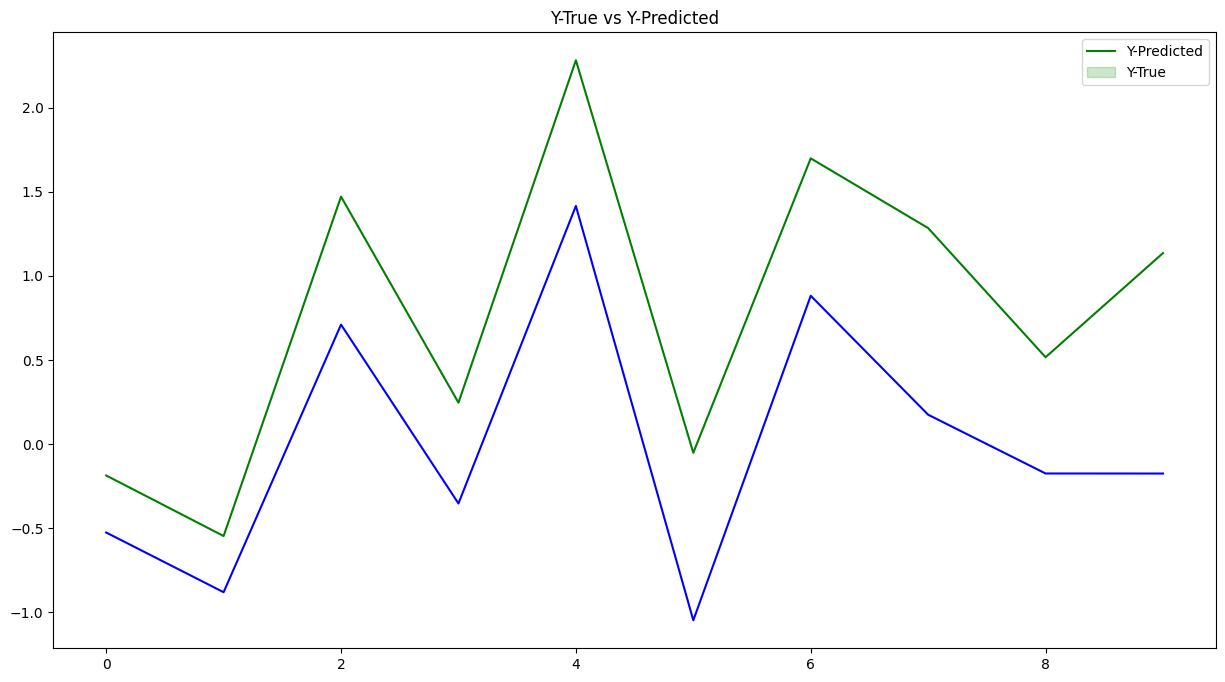

[*********************100%%**********************]  1 of 1 completed

1213.TW


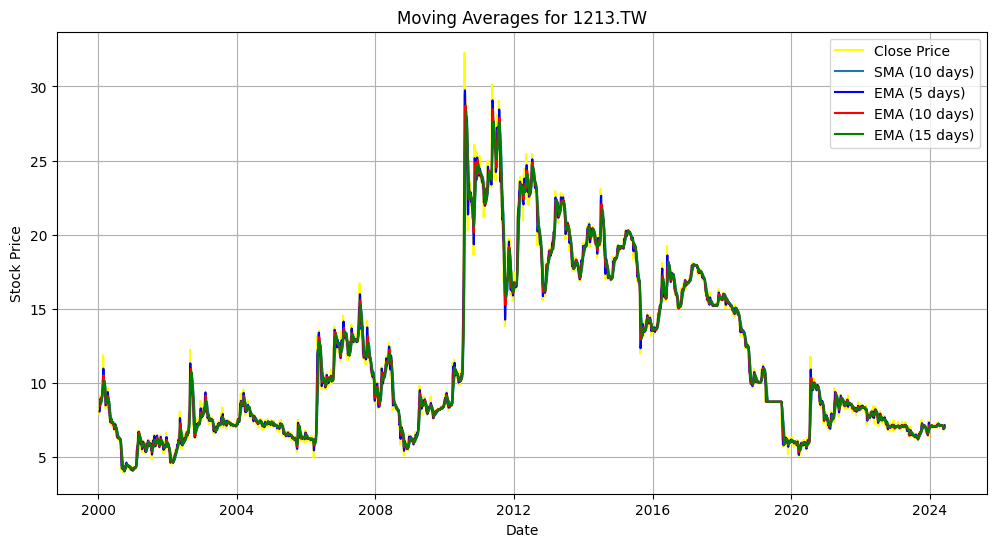

大飲


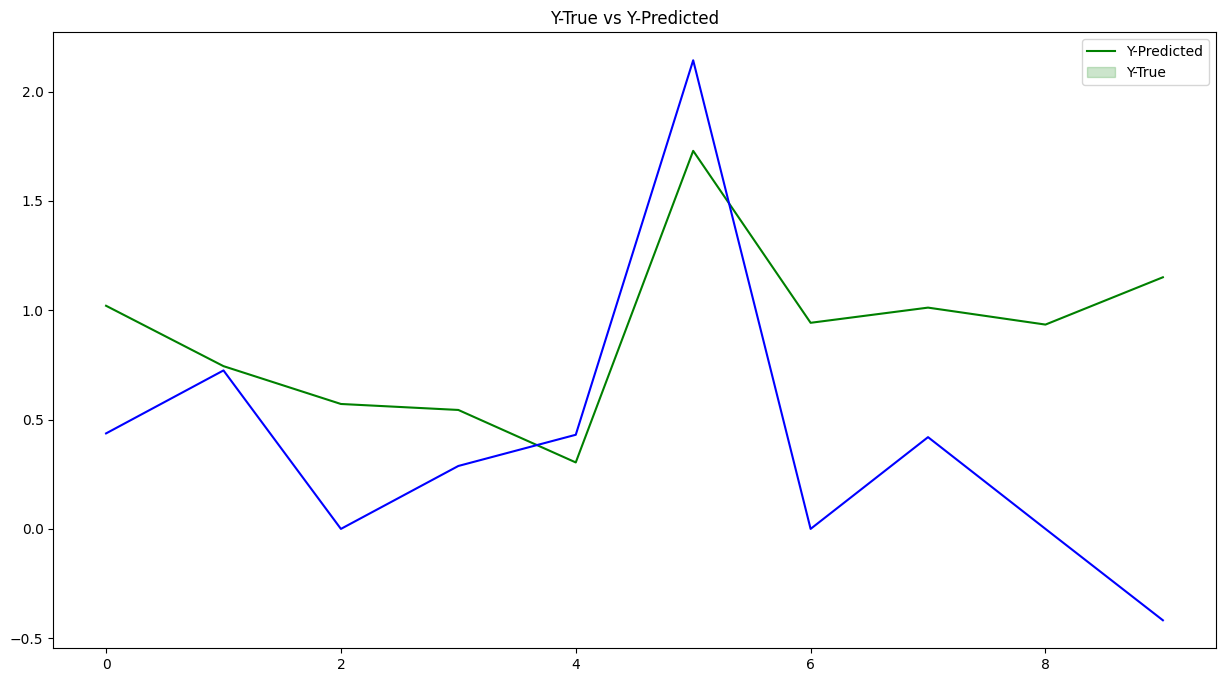

1215.TW


[*********************100%%**********************]  1 of 1 completed


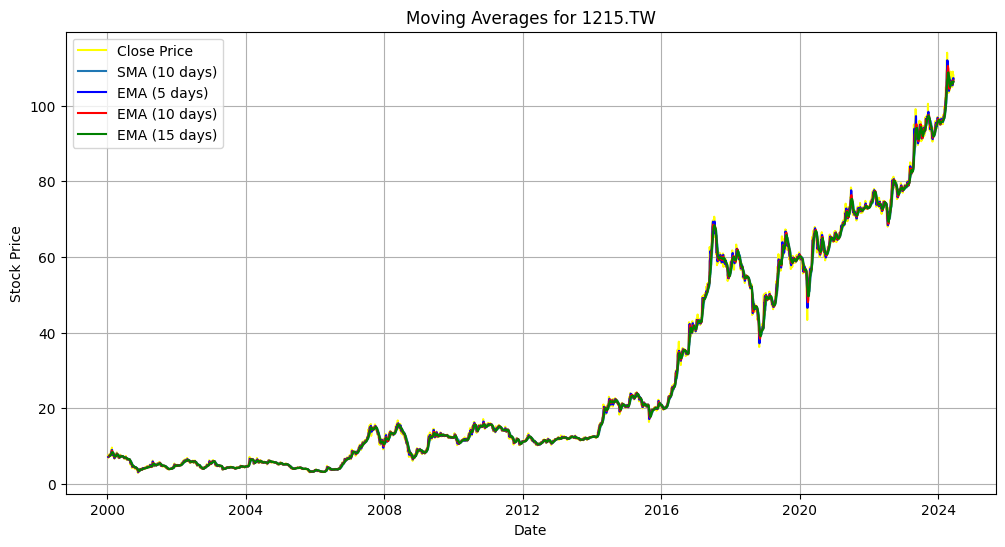

卜蜂


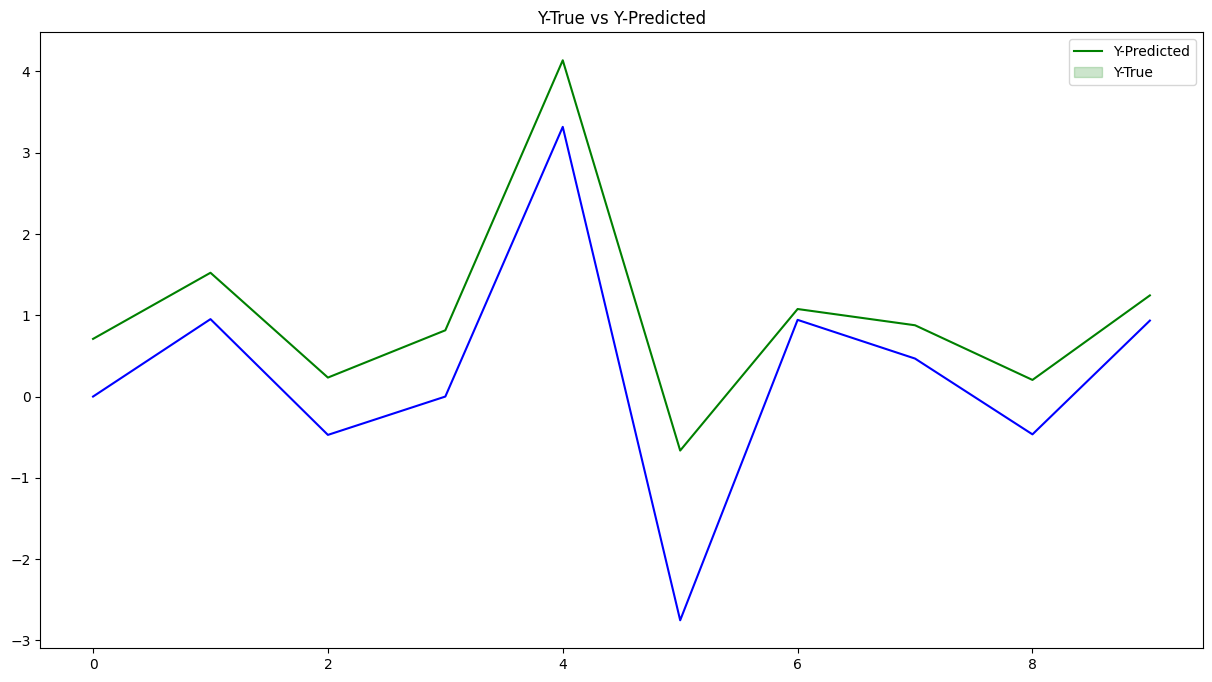

1216.TW


[*********************100%%**********************]  1 of 1 completed


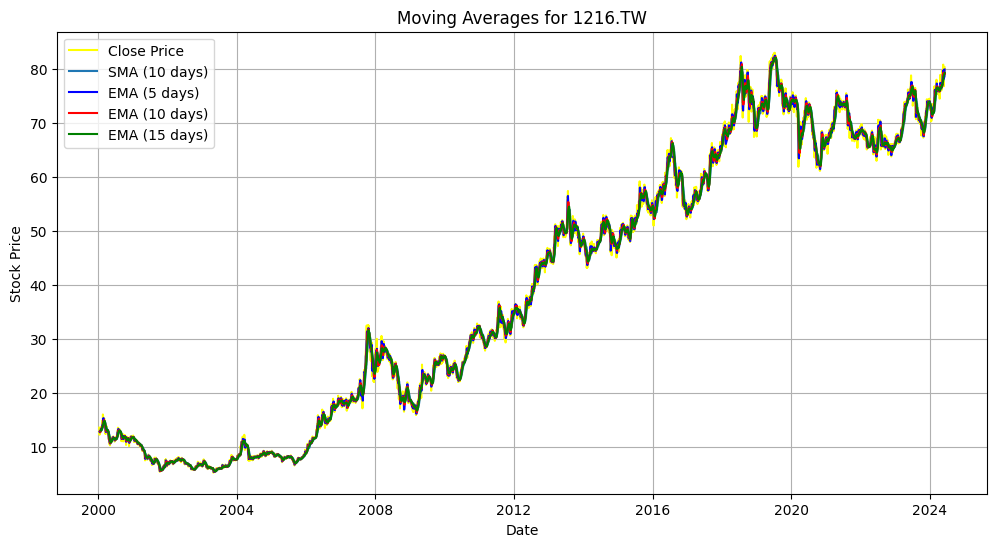

統一


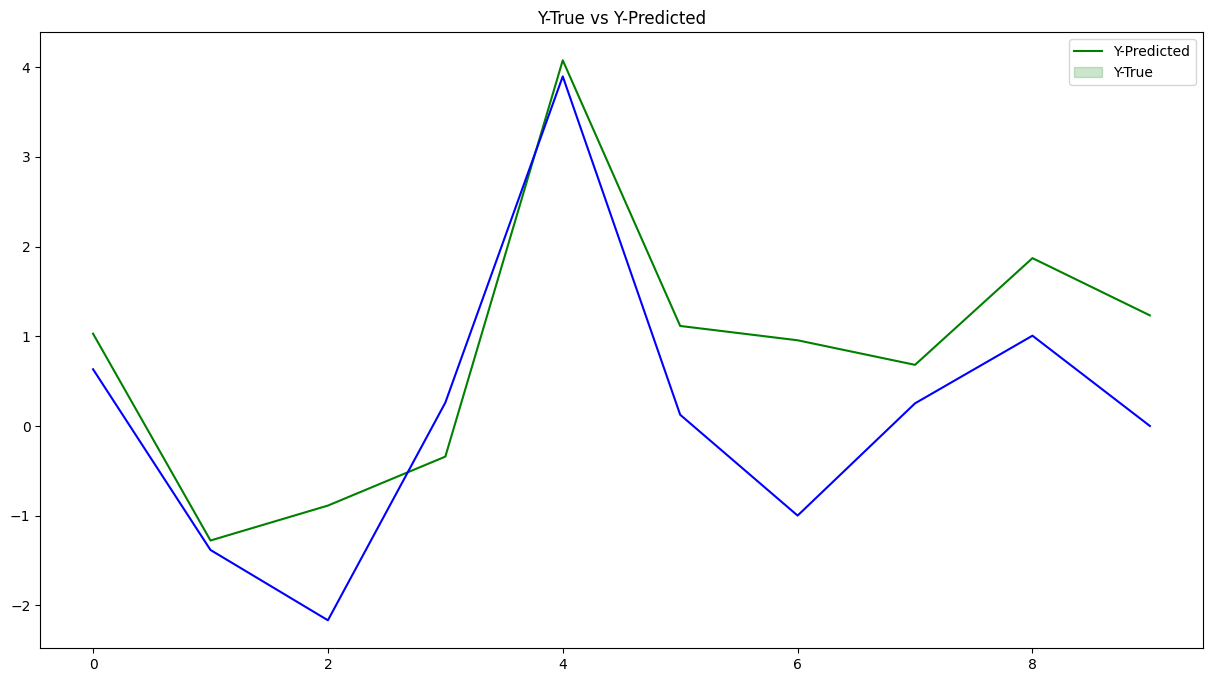

1217.TW


[*********************100%%**********************]  1 of 1 completed


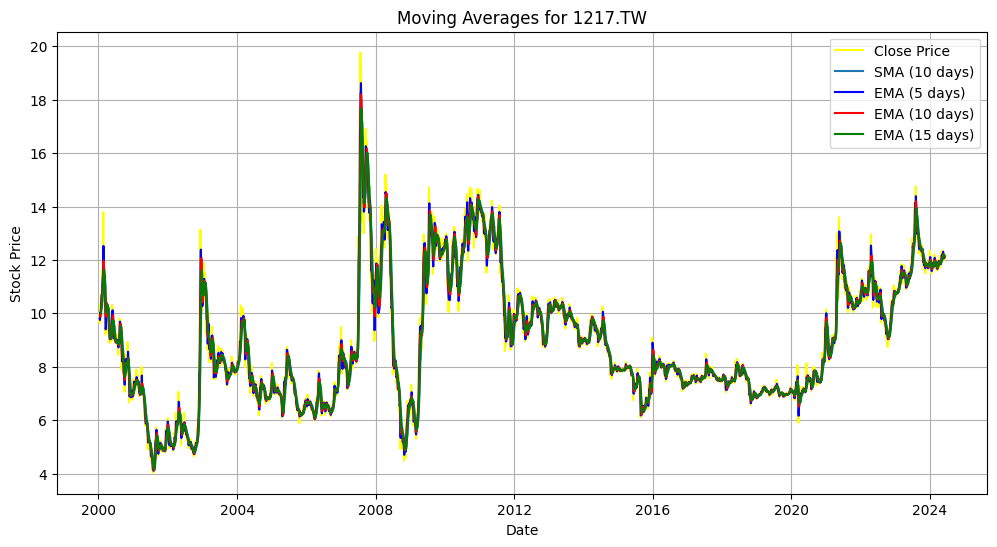

愛之味


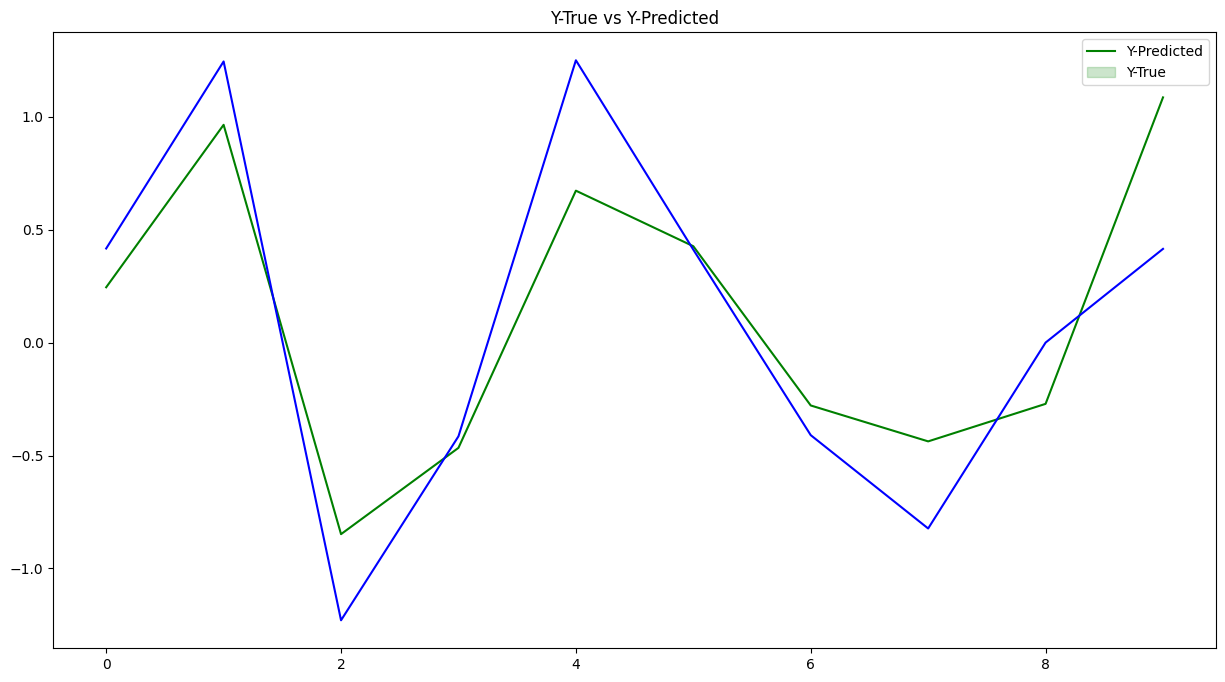

1218.TW


[*********************100%%**********************]  1 of 1 completed


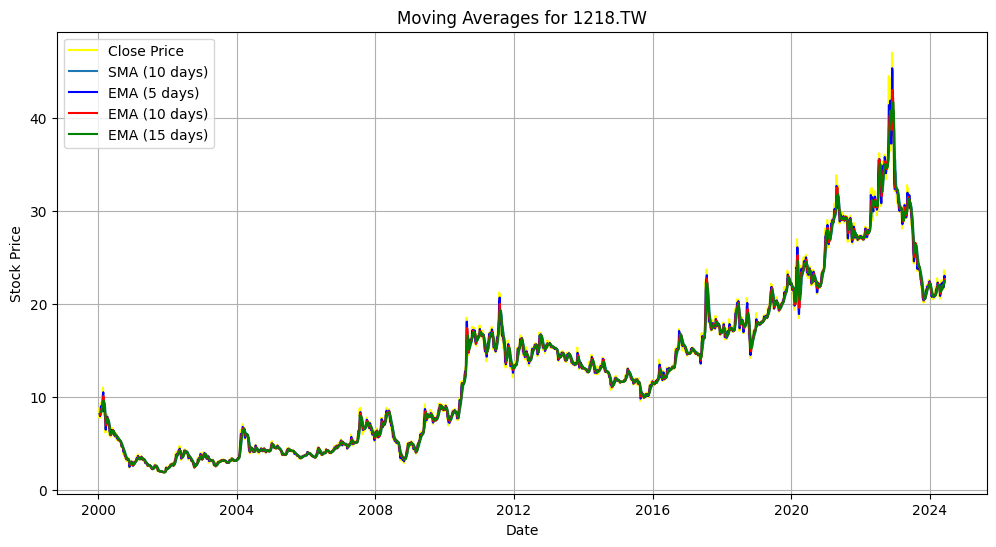

泰山


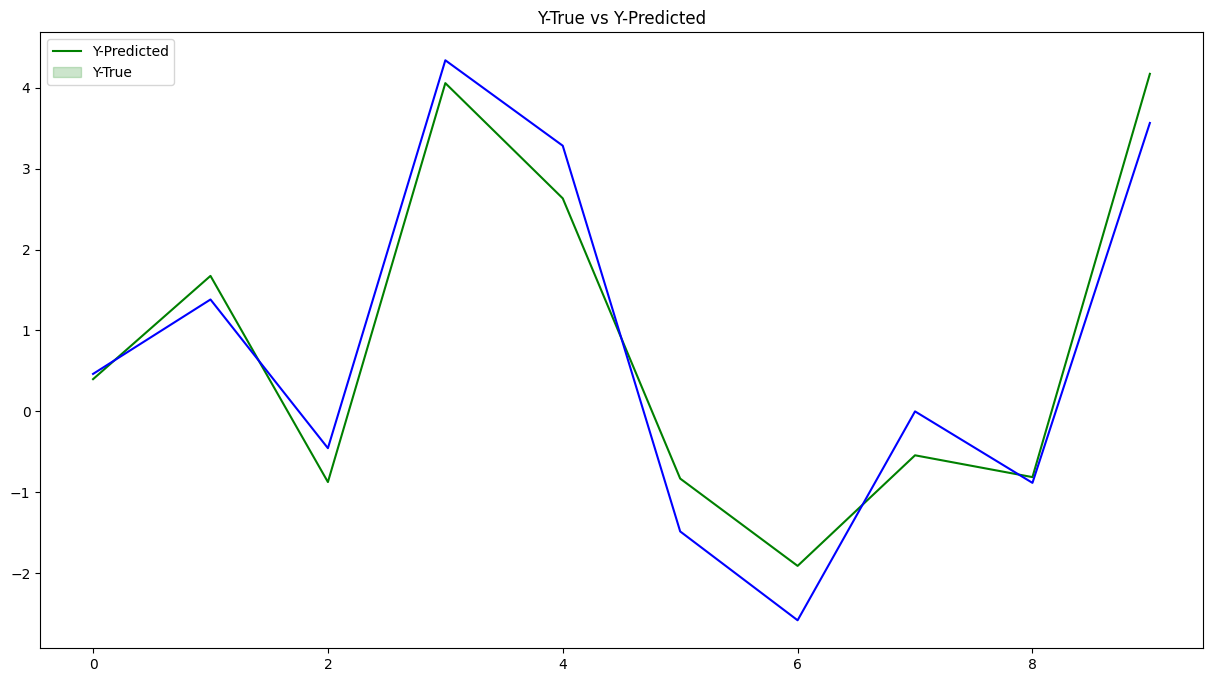

1219.TW


[*********************100%%**********************]  1 of 1 completed


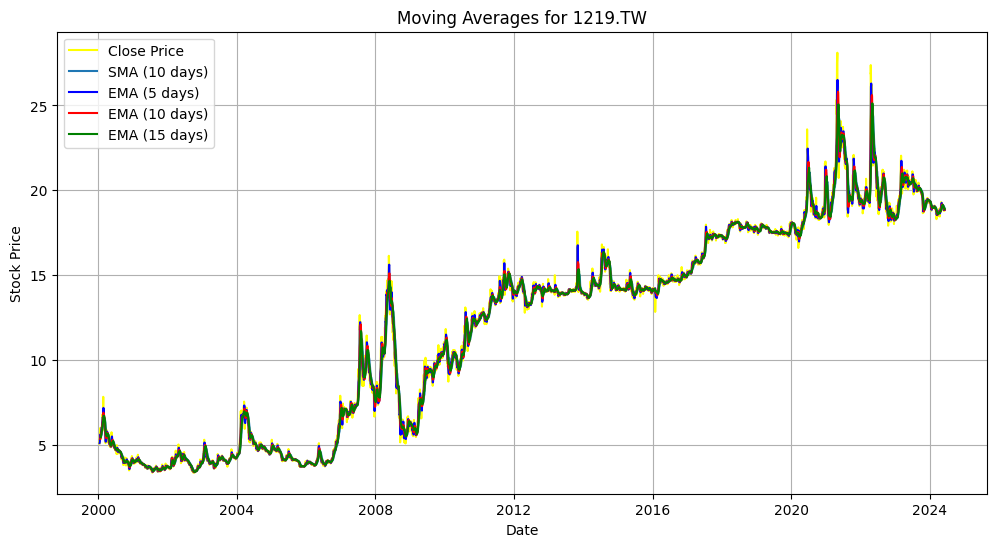

福壽


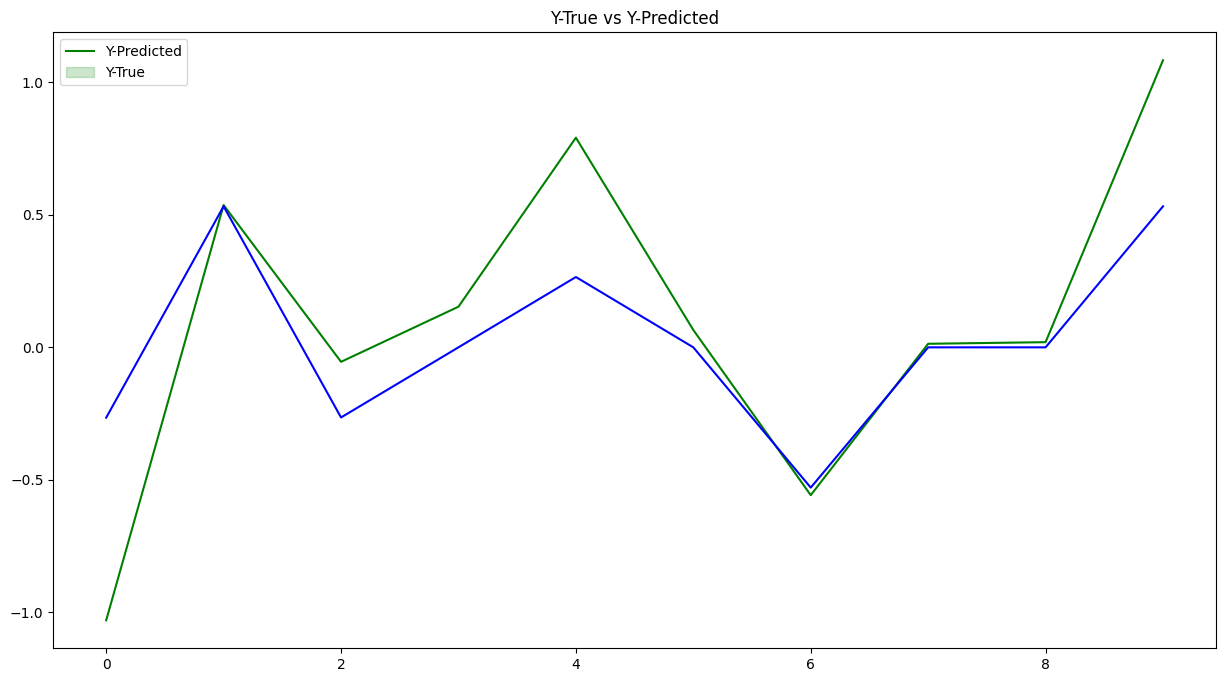

1220.TW


[*********************100%%**********************]  1 of 1 completed


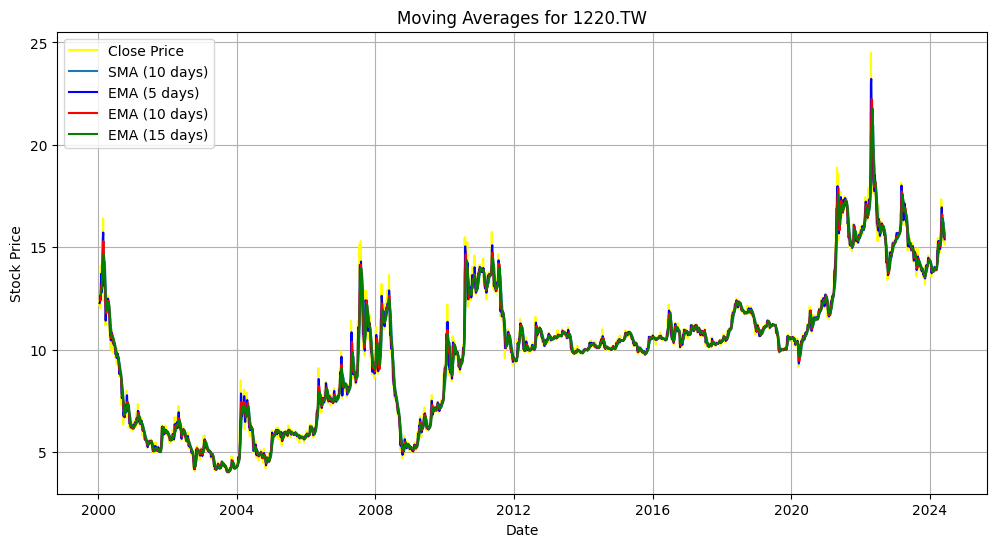

台榮


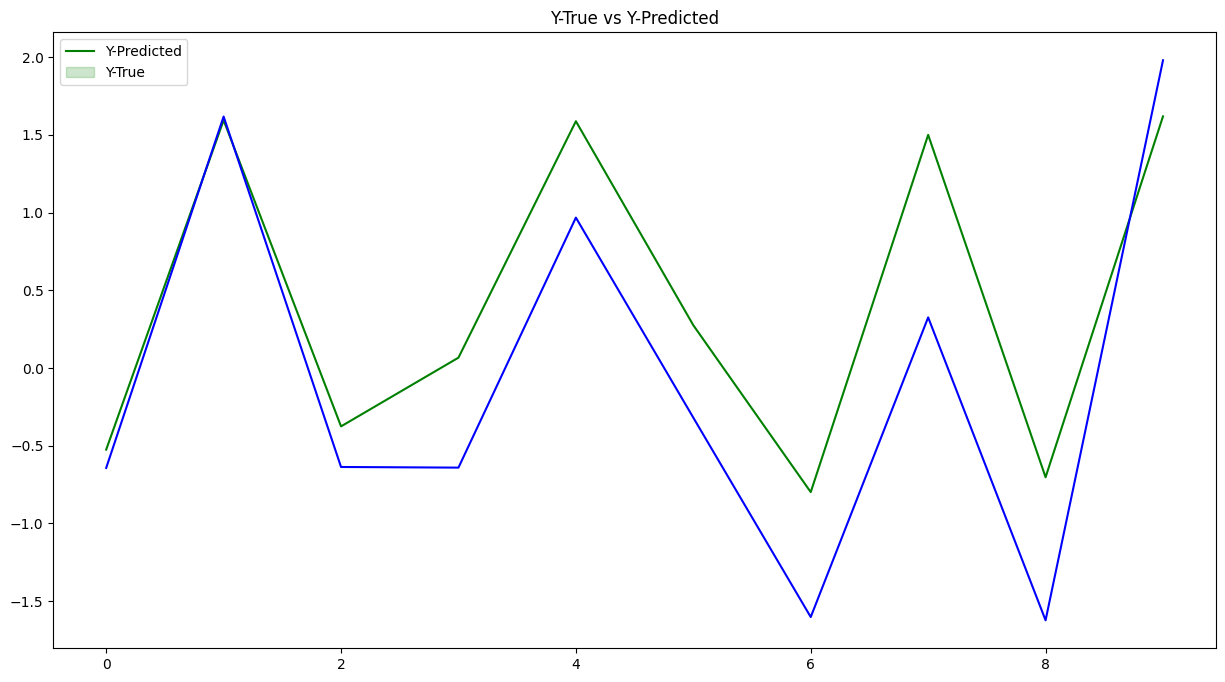

1225.TW


[*********************100%%**********************]  1 of 1 completed


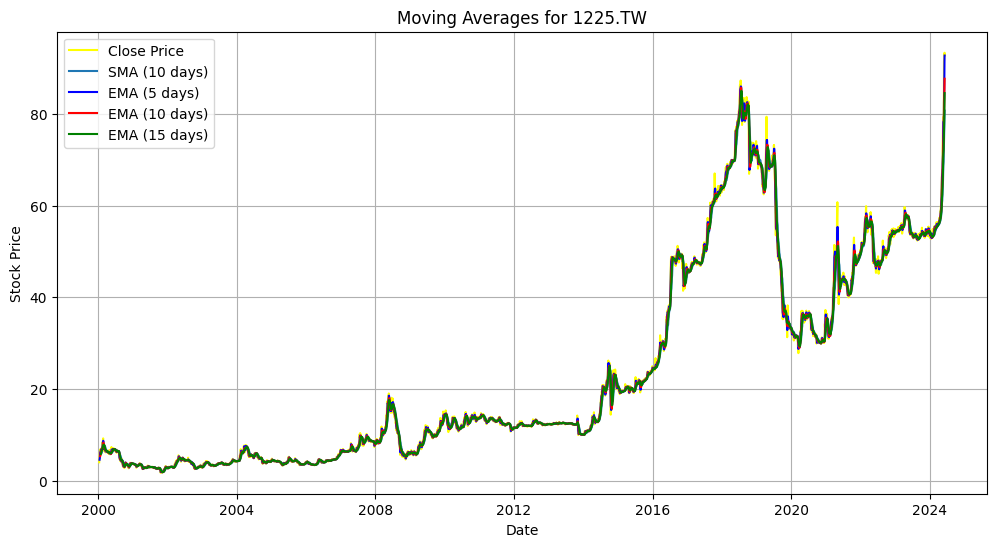

福懋油


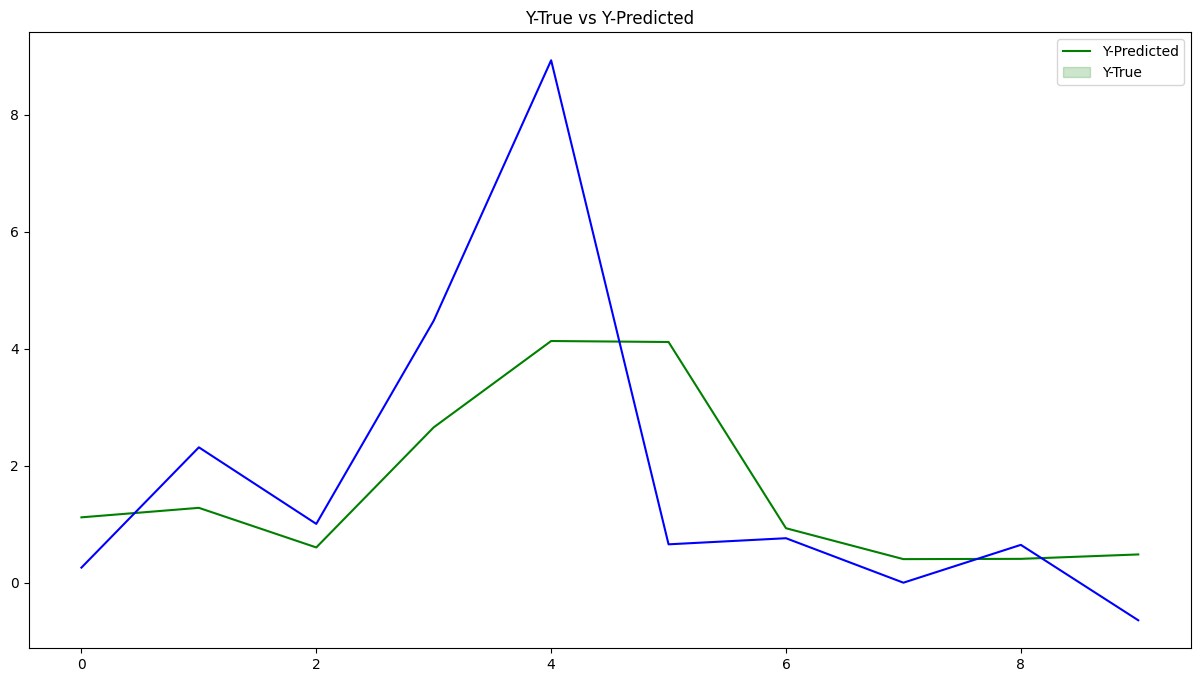

1227.TW


[*********************100%%**********************]  1 of 1 completed


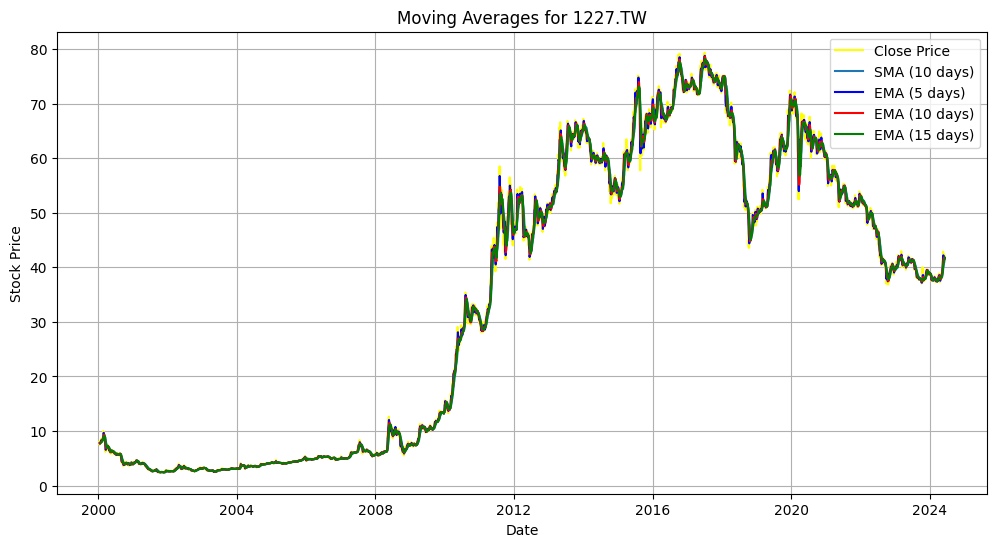

佳格


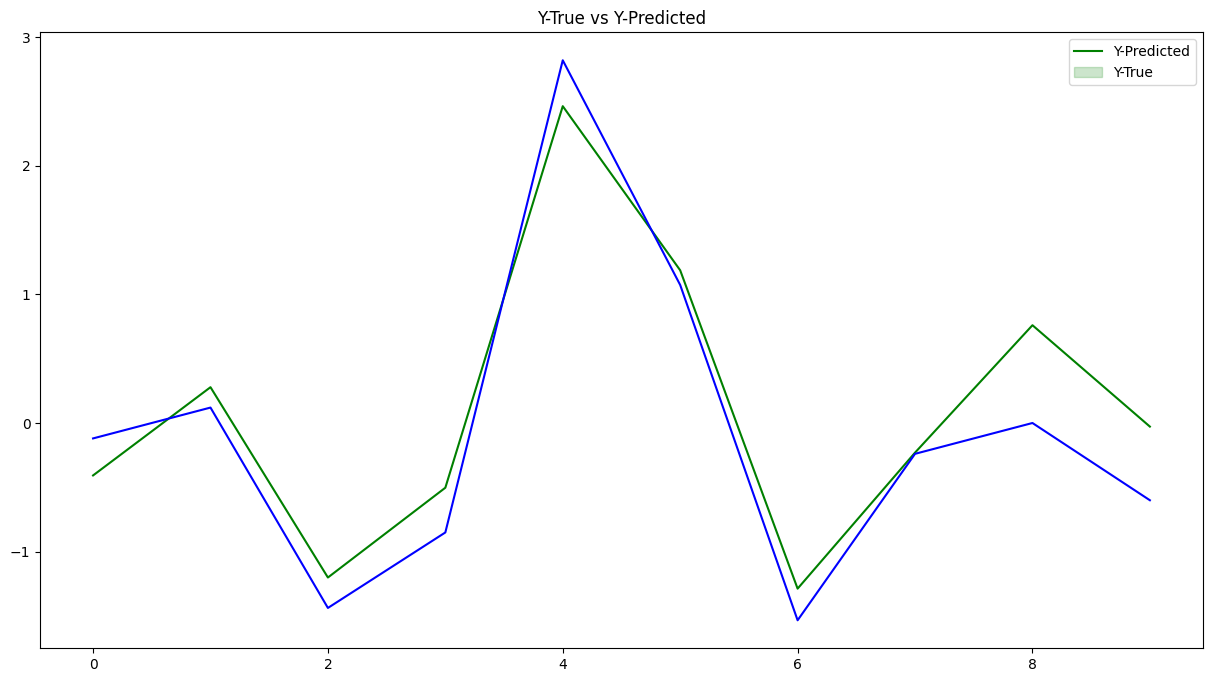

1229.TW


[*********************100%%**********************]  1 of 1 completed


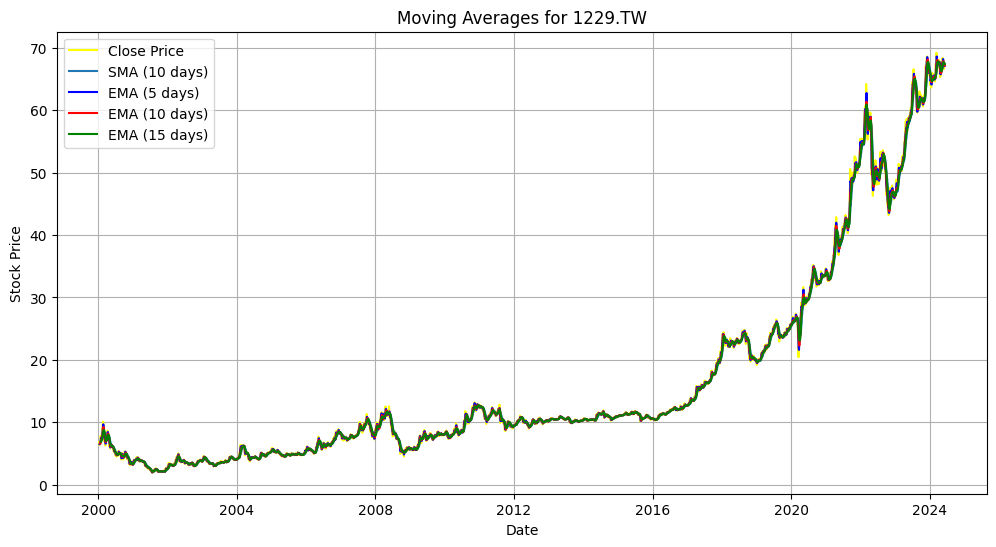

聯華


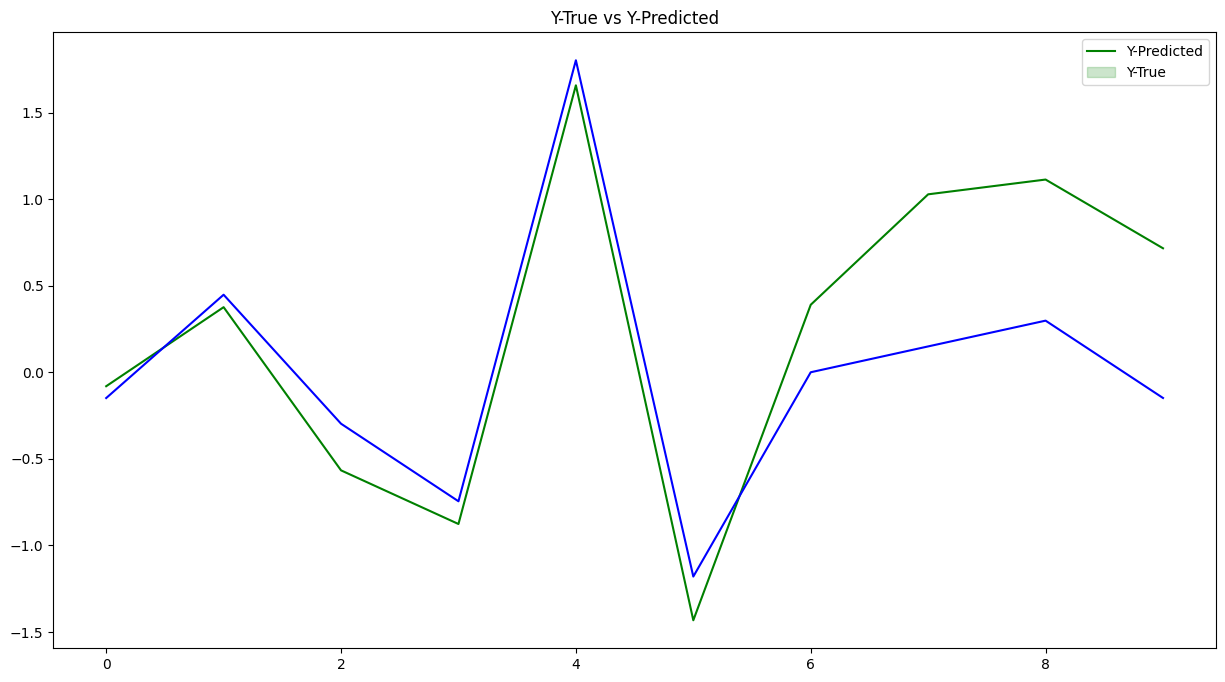

1231.TW


[*********************100%%**********************]  1 of 1 completed


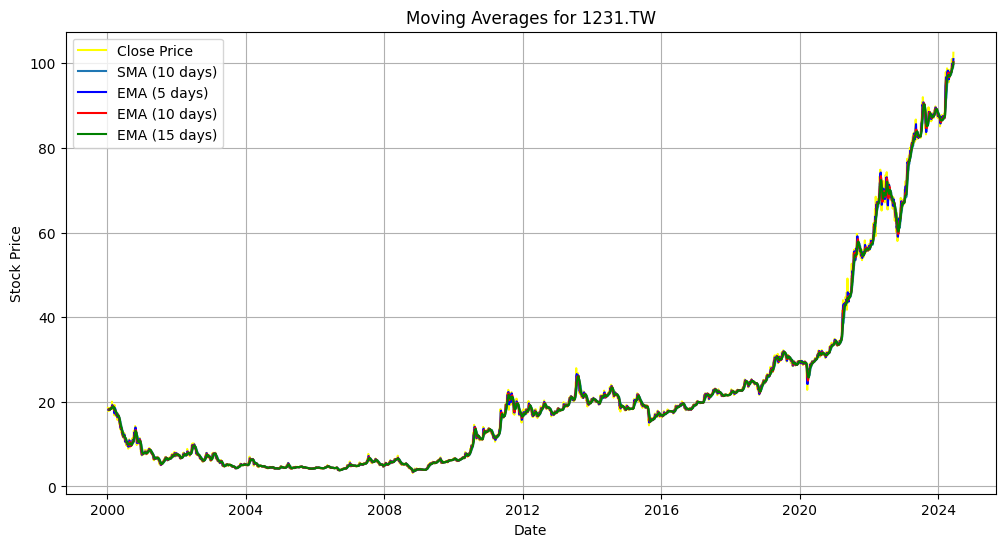

聯華食


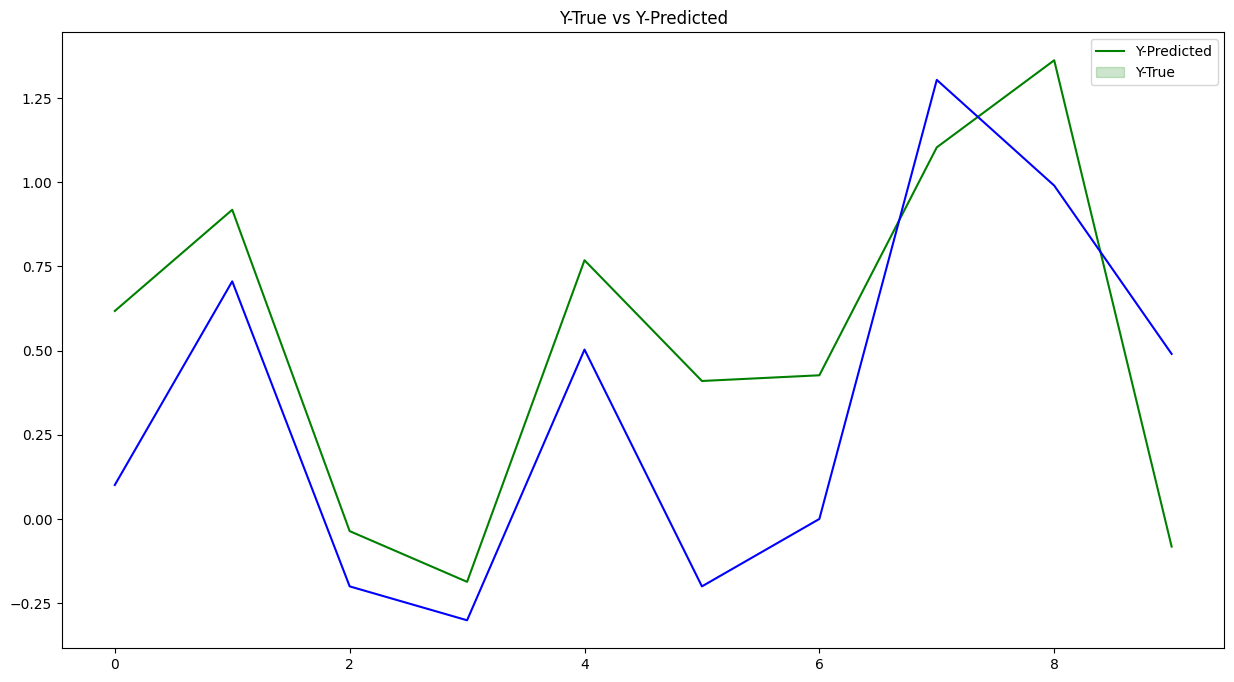

1232.TW


[*********************100%%**********************]  1 of 1 completed


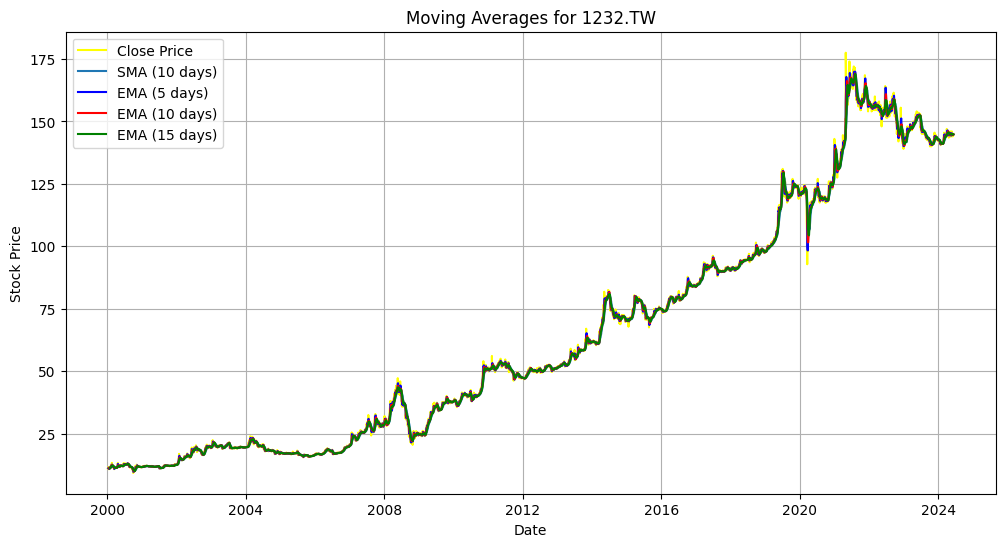

大統益


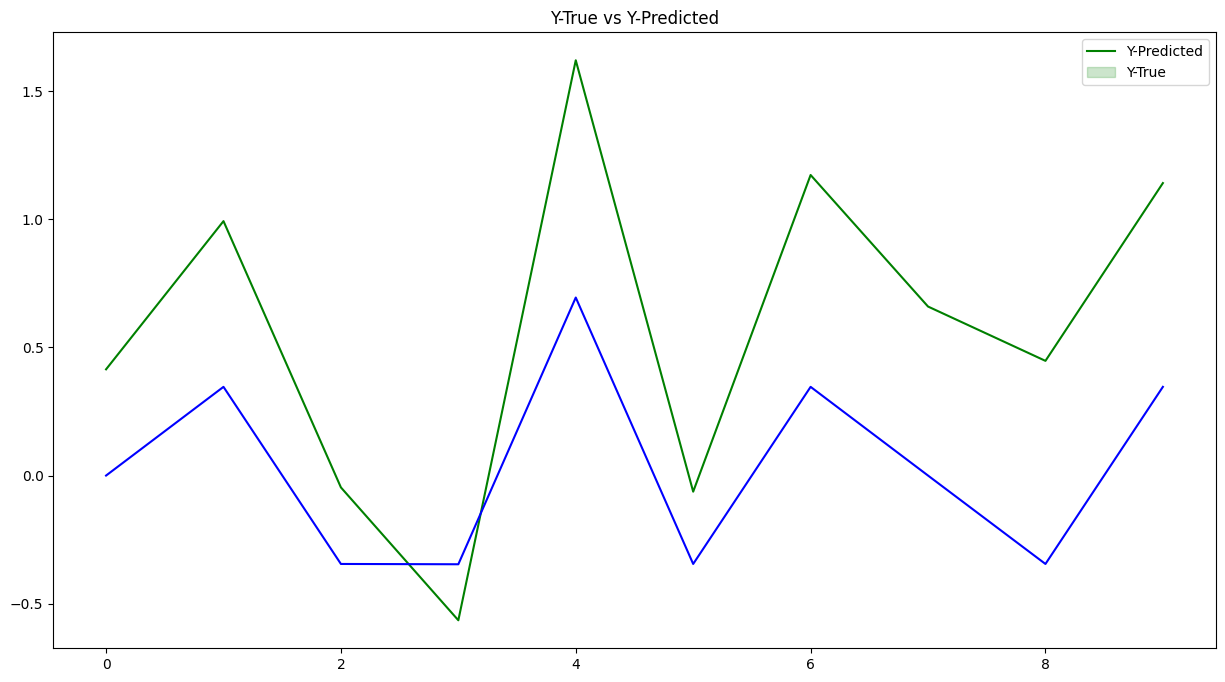

1233.TW


[*********************100%%**********************]  1 of 1 completed


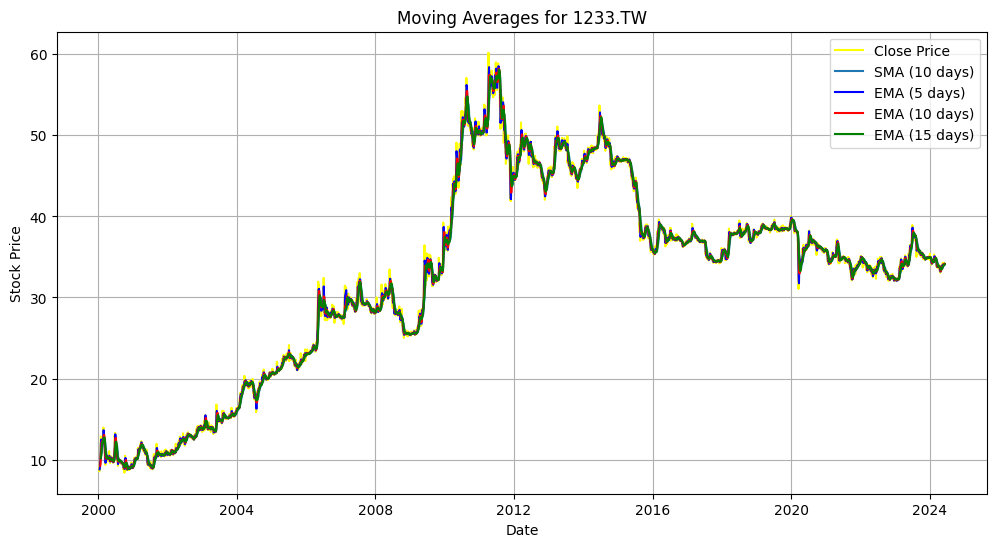

天仁


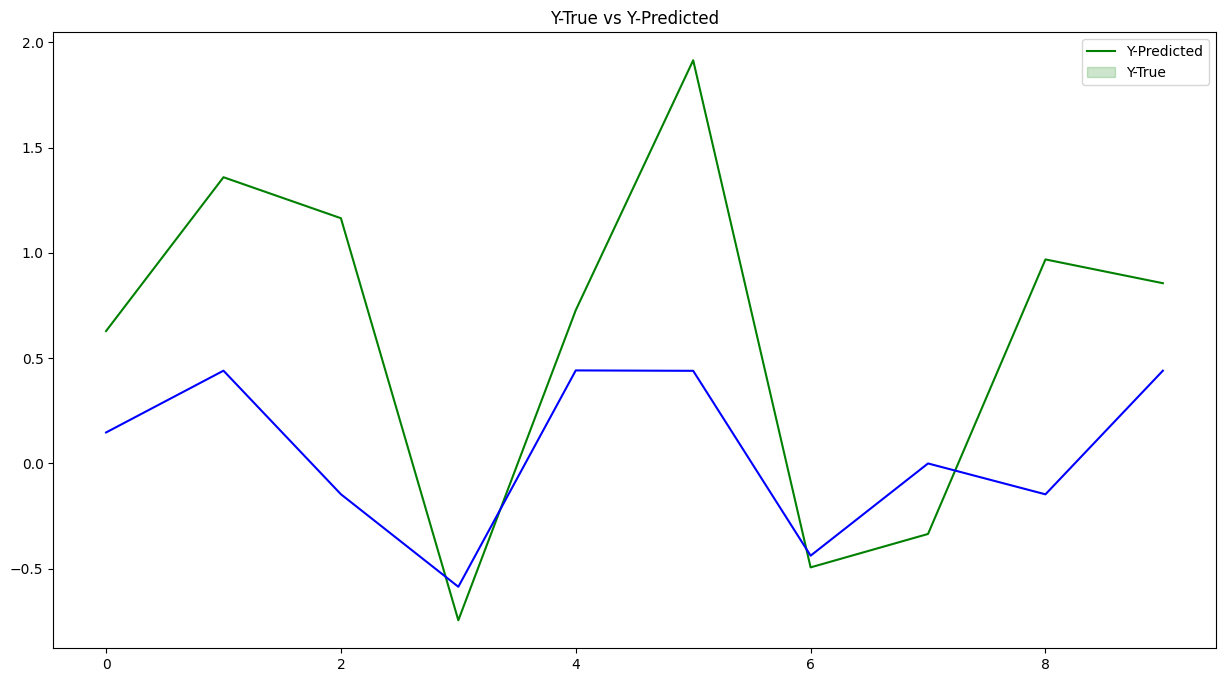

1234.TW


[*********************100%%**********************]  1 of 1 completed


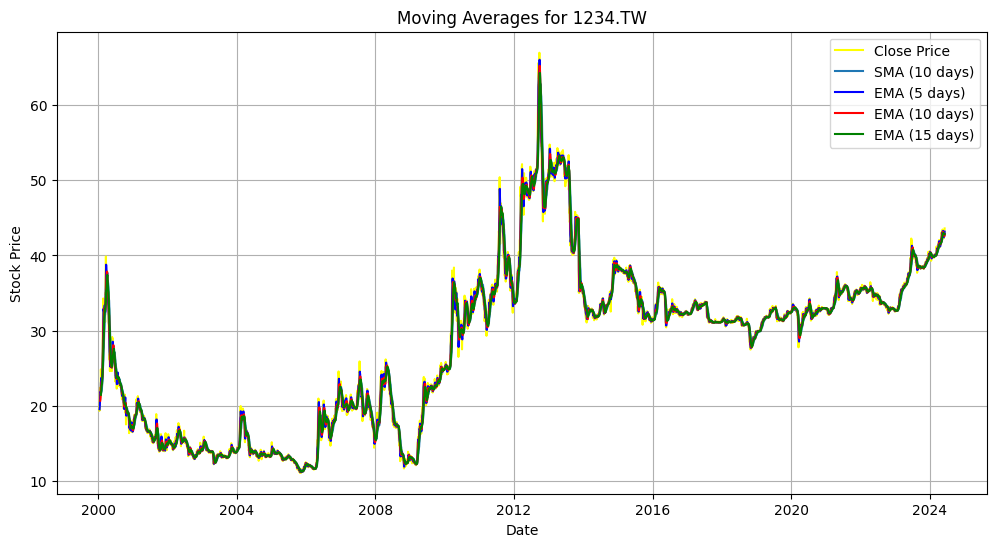

黑松


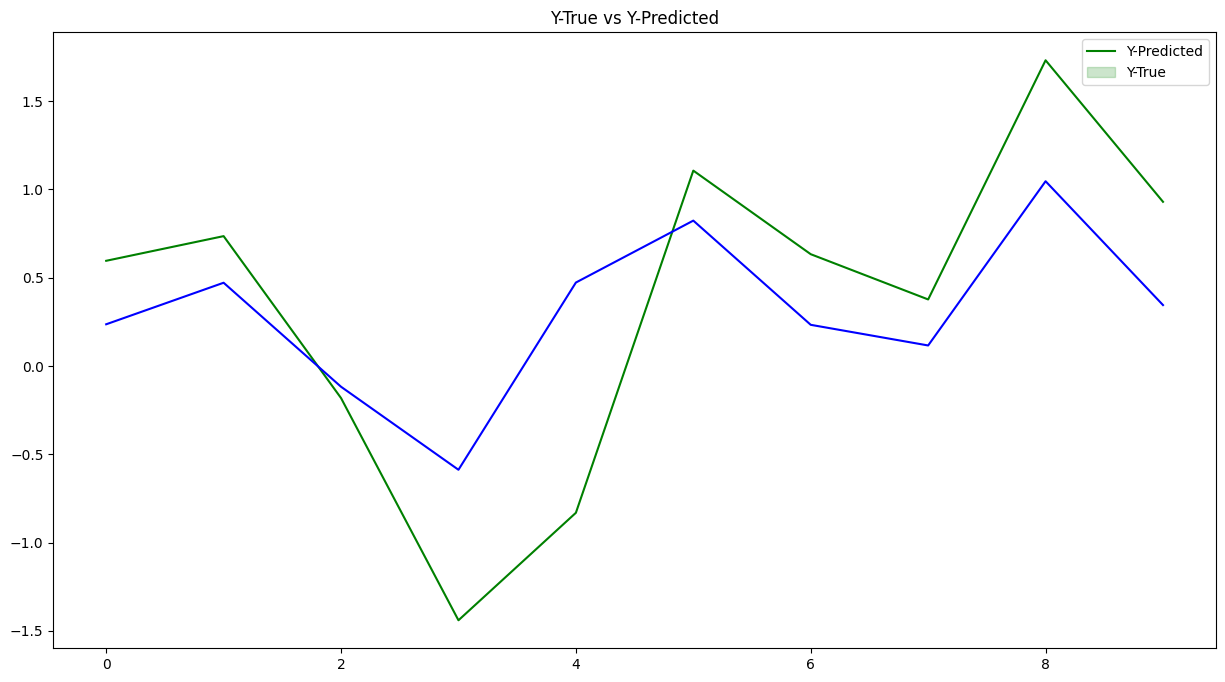

1235.TW


[*********************100%%**********************]  1 of 1 completed


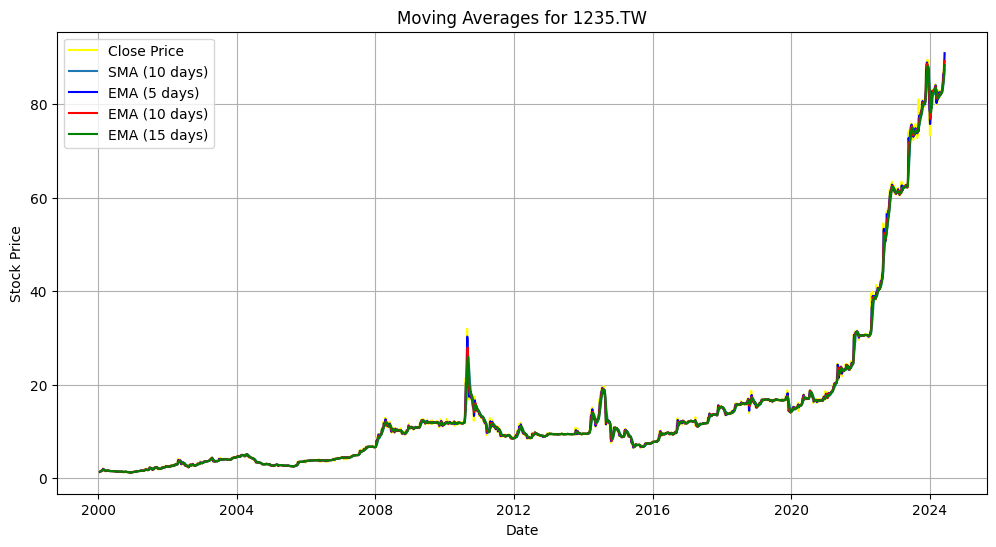

興泰


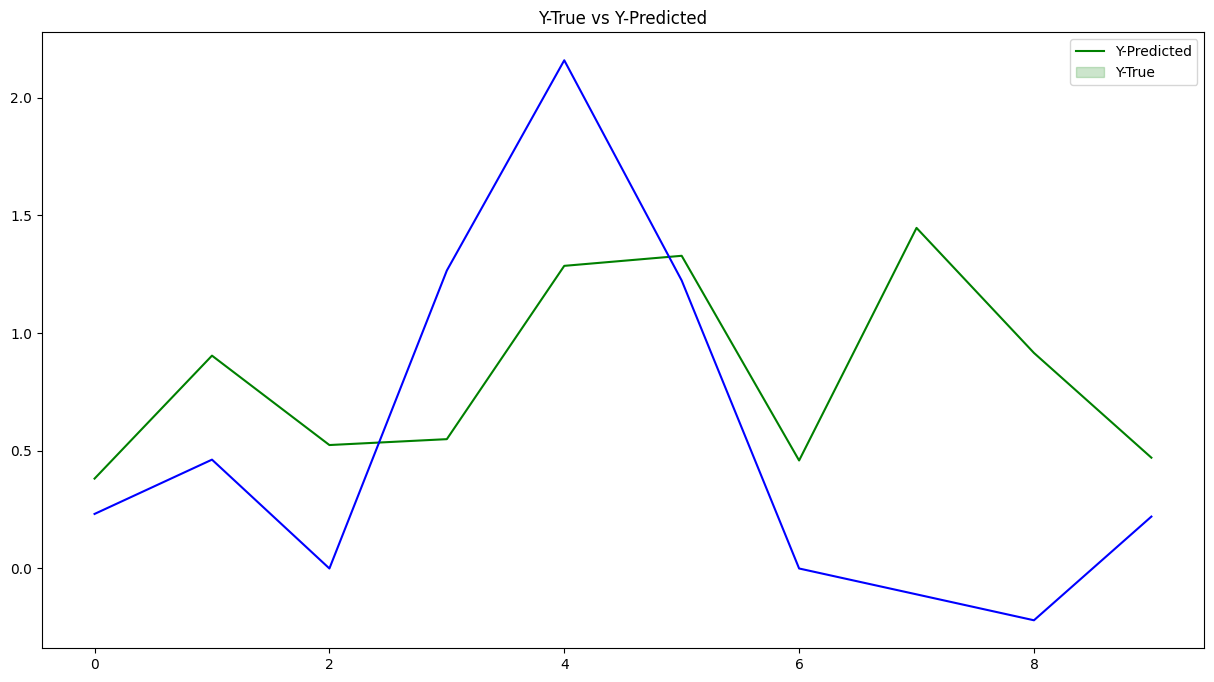

1236.TW


[*********************100%%**********************]  1 of 1 completed


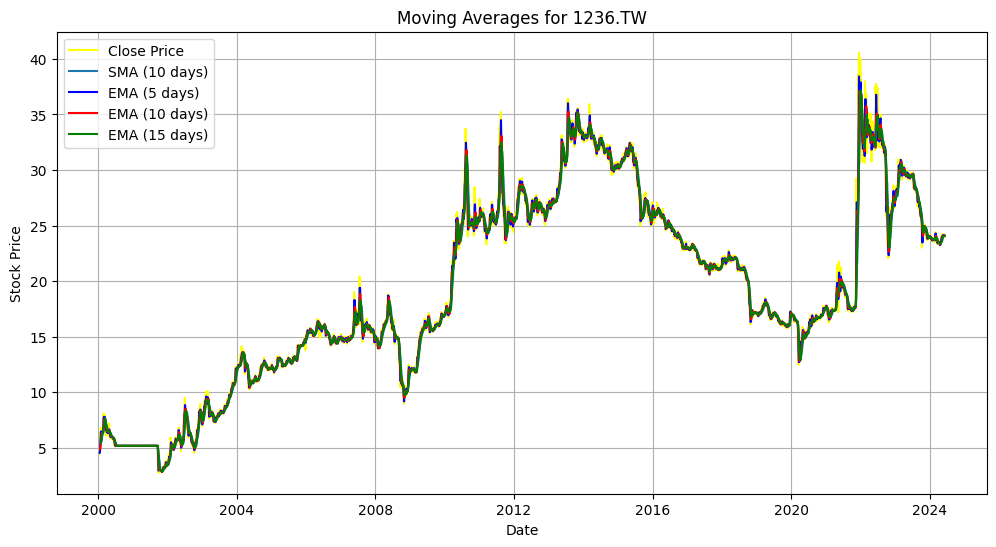

宏亞


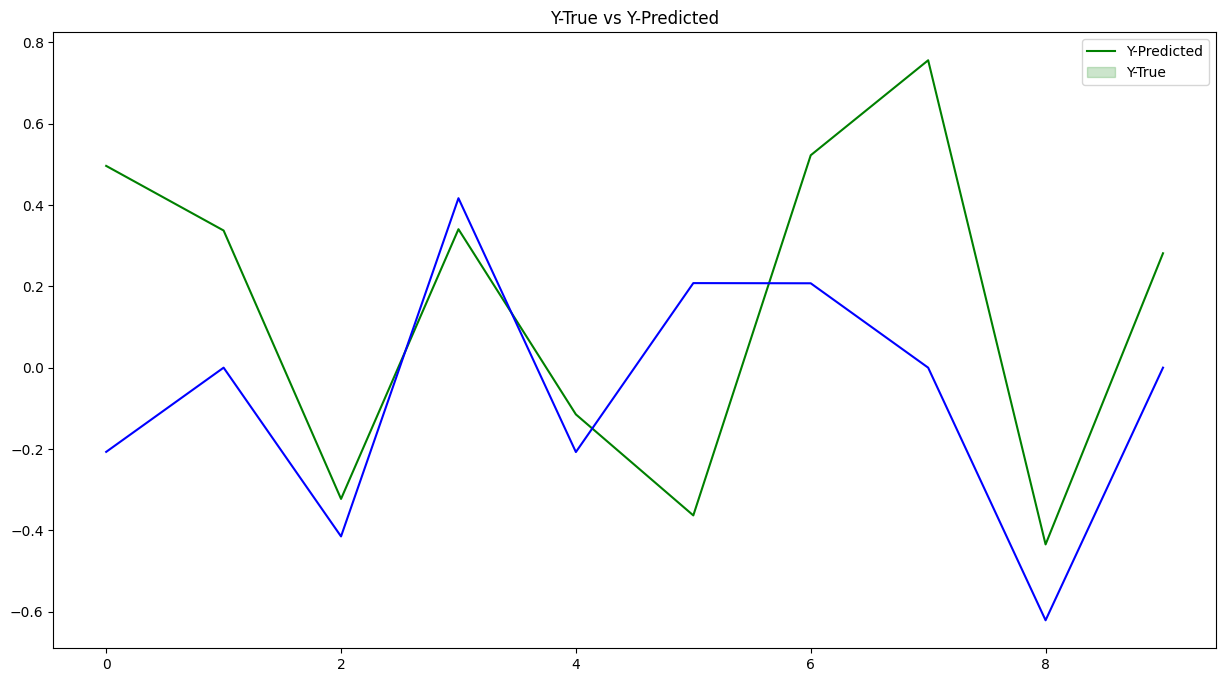

[*********************100%%**********************]  1 of 1 completed

1256.TW


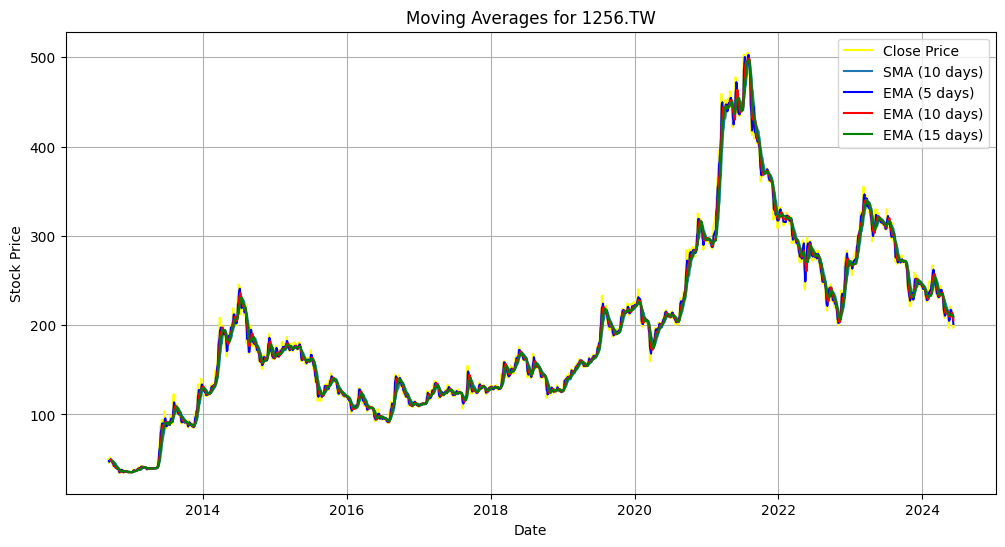

鮮活果汁-KY


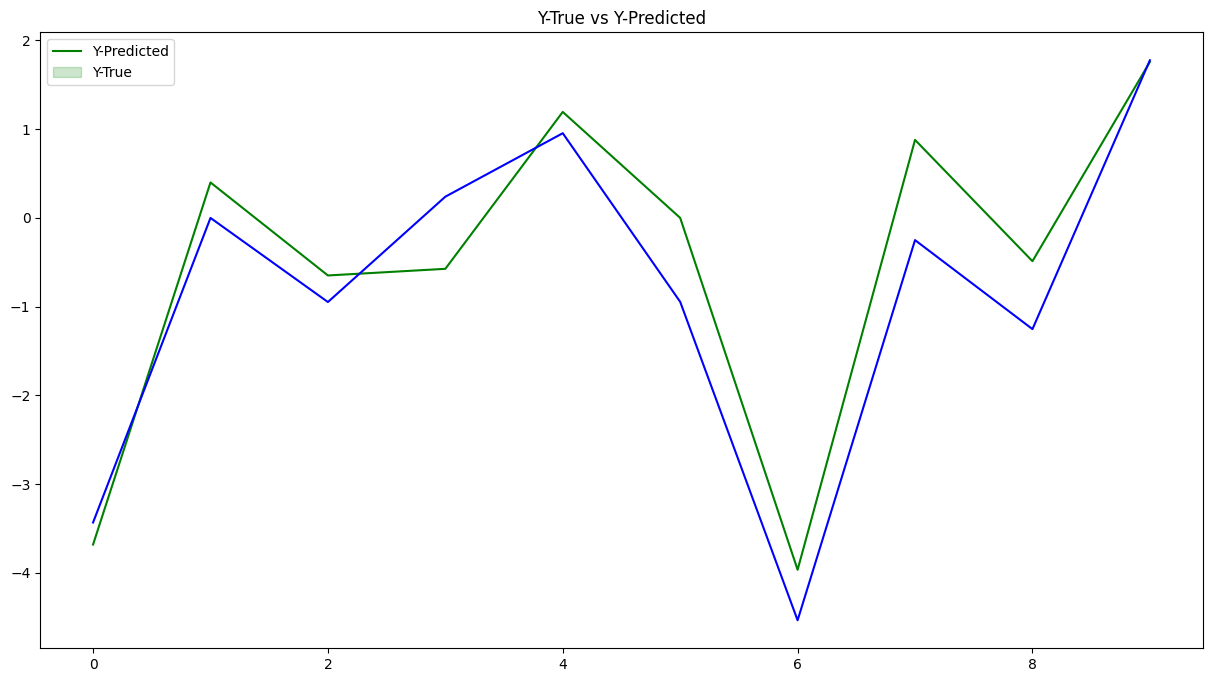

1301.TW


[*********************100%%**********************]  1 of 1 completed


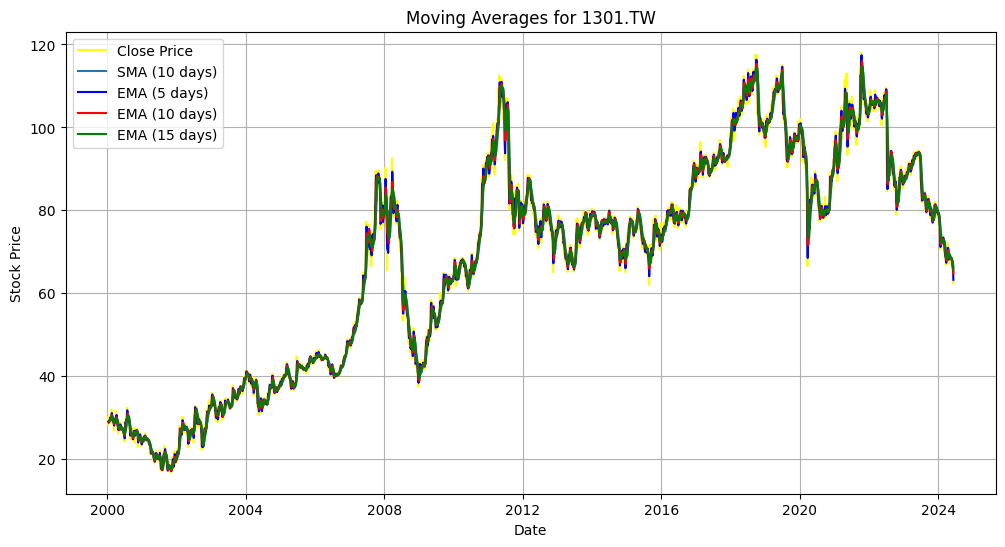

台塑


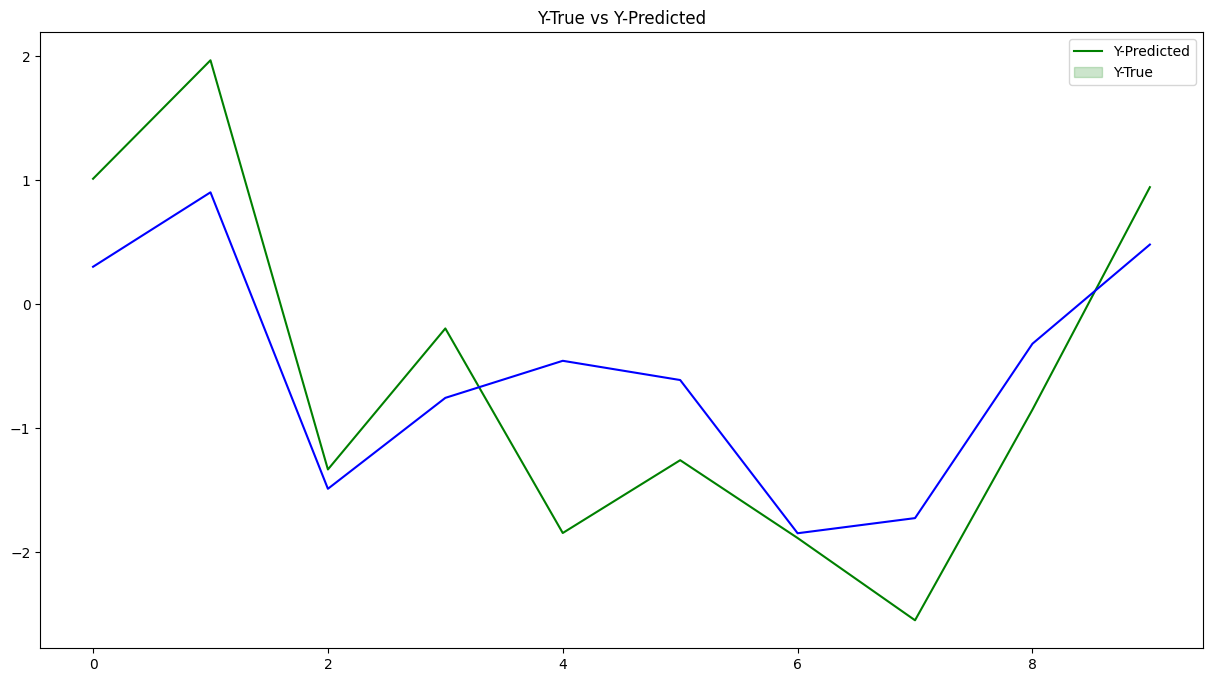

In [ ]:
for i, ticker in enumerate(code):
  print(ticker)
  data = yf.download(ticker,start="2000-1-10")
  data.dropna(inplace=True)
  moving_average, trend = calculate_and_plot_moving_averages(data)
  labelencode(moving_average)
  moving_average = clean_dataset(moving_average)
  min_max_scaler = StandardScaler()
  moving_average.dropna(inplace=True)
  moving_average = min_max_scaler.fit_transform(moving_average)
  y_pred = loaded_model.predict(moving_average)
  trend = trend.values.reshape(-1)
  print(name[i])
  plt.figure(figsize=(15,8))

  sns.lineplot(y=y_pred[-10:],x=np.arange(10),c='green')
  sns.lineplot(y=trend[-10:],x=np.arange(10),c='blue')
  plt.legend(['Y-Predicted','Y-True'])
  plt.title('Y-True vs Y-Predicted')
  plt.show()

In [ ]:
data = yf.download(ticker,start="2005-1-10")

[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['1101']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


In [ ]:
# prompt: moving average preprocessomg

# Min-max scaling



# Split data into features and target


# Split the data into train, validation, and test sets



In [ ]:
moving_average

array([[-1.66715594, -1.66858097, -1.66412085, ..., -0.1903502 ,
        -0.61758393, -0.03714148],
       [-1.67213466, -1.6834491 , -1.65905041, ...,  0.06435122,
         0.05403066, -0.01834896],
       [-1.67716318, -1.68843807, -1.66412085, ...,  0.06435122,
         0.05403066, -0.00784759],
       ...,
       [ 3.05764283,  3.24045849,  3.02618591, ...,  3.87940046,
         1.76921552, -0.02398257],
       [ 3.40739437,  3.40569681,  3.32847195, ..., -3.32680366,
        -1.3823776 , -0.02752431],
       [ 3.27415569,  3.30655382,  3.29488461, ...,  0.06435122,
         0.05403066, -0.04448404]])

In [ ]:
moving_average

Open        High         Low       Close   Adj Close  \
Date                                                                     
2000-01-04   21.226839   22.112152   20.965843   21.935089   12.536087   
2000-01-05   21.672945   22.466278   21.495884   21.935089   12.536087   
2000-01-06   22.027071   22.466278   21.403902   21.935089   12.536087   
2000-01-07   21.226839   21.672945   20.872713   21.049776   12.030126   
2000-01-10   21.226839   21.850008   20.872713   21.495884   12.285079   
...                ...         ...         ...         ...         ...   
2024-06-03  177.000000  179.500000  174.500000  176.500000  176.500000   
2024-06-04  175.000000  176.500000  170.000000  171.000000  171.000000   
2024-06-05  171.000000  178.000000  168.500000  175.500000  175.500000   
2024-06-06  181.500000  183.000000  177.500000  177.500000  177.500000   
2024-06-07  177.500000  180.000000  176.500000  177.500000  177.500000   

               Volume       EMA_9         5MA    10MA       15SMA  ...  \
Date                                                               ...   
2000-01-04  100969038   21.935089         NaN     NaN         NaN  ...   
2000-01-05   78951612   21.935089         NaN     NaN         NaN  ...   
2000-01-06   94351308   21.935089         NaN     NaN         NaN  ...   
2000-01-07   63538583   21.677656         NaN     NaN         NaN  ...   
2000-01-10   71348563   21.633268   21.670185     NaN         NaN  ...   
...               ...         ...         ...     ...         ...  ...   
2024-06-03   89188697  172.100827  178.200000  176.00  174.100000  ...   
2024-06-04  101915226  171.990744  175.300000  176.50  174.033333  ...   
2024-06-05  117365054  172.341670  174.300000  177.15  174.366667  ...   
2024-06-06  121092025  172.857503  174.500000  177.60  174.766667  ...   
2024-06-07   55448022  173.321752  175.600000  177.75  175.266667  ...   

            Is_quarter_end  Is_quarter_start  Is_year_end  Is_year_start  \
Date                                                                       
2000-01-04               0                 0            0              0   
2000-01-05               0                 0            0              0   
2000-01-06               0                 0            0              0   
2000-01-07               0                 0            0              0   
2000-01-10               0                 0            0              0   
...                    ...               ...          ...            ...   
2024-06-03               0                 0            0              0   
2024-06-04               0                 0            0              0   
2024-06-05               0                 0            0              0   
2024-06-06               0                 0            0              0   
2024-06-07               0                 0            0              0   

                5volume    10volume       3volume  price_change  \
Date                                                              
2000-01-04          NaN         NaN           NaN      0.708250   
2000-01-05          NaN         NaN           NaN      0.262144   
2000-01-06          NaN         NaN  9.142399e+07     -0.091982   
2000-01-07          NaN         NaN  7.894717e+07     -0.177063   
2000-01-10   81831820.8         NaN  7.641282e+07      0.269045   
...                 ...         ...           ...           ...   
2024-06-03   91610161.0  82655414.8  1.050110e+08     -0.500000   
2024-06-04   98432380.2  88197078.9  1.127486e+08     -4.000000   
2024-06-05  106862665.6  94413144.3  1.028230e+08      4.500000   
2024-06-06  115340572.4  98164582.5  1.134574e+08     -4.000000   
2024-06-07   97001804.8  96786828.9  9.796837e+07      0.000000   

            price_change_pct  volume_pct  
Date                                      
2000-01-04          0.033366         NaN  
2000-01-05          0.012095   -0.218061  
2000-01-06         -0.004176    0.195052  
2000-01-07      

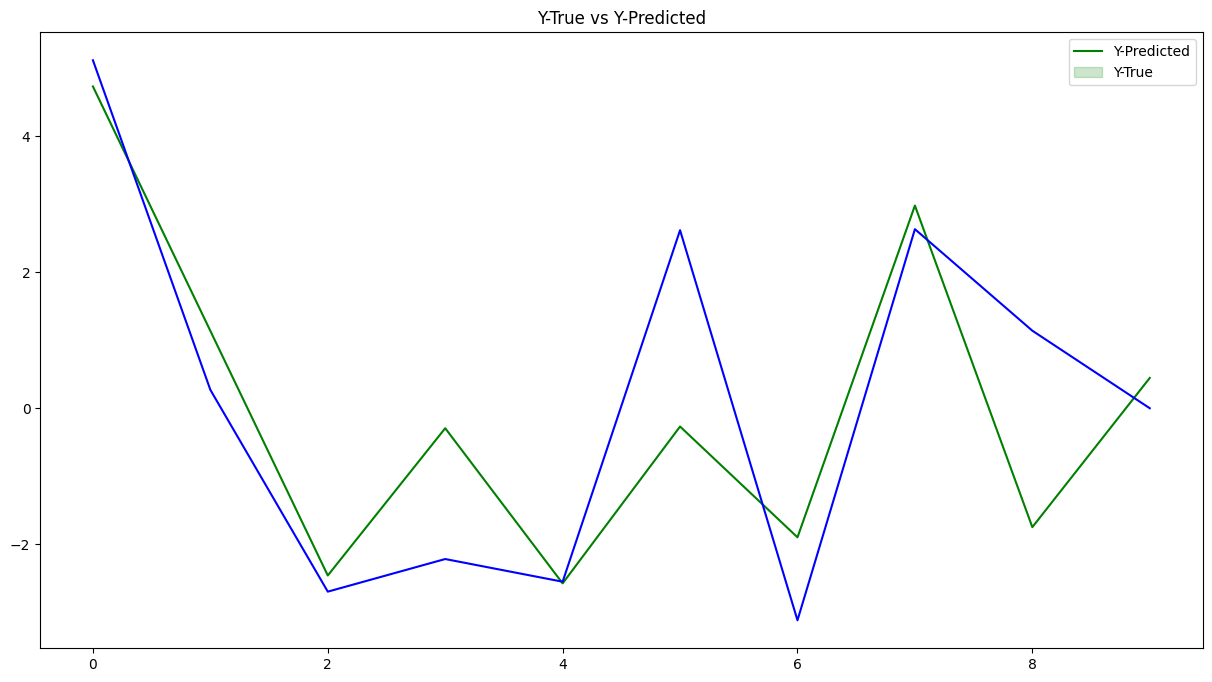

In [ ]:
y_pred = loaded_model.predict(moving_average)
trend = trend.values.reshape(-1)
plt.figure(figsize=(15,8))
sns.lineplot(y=y_pred[-10:],x=np.arange(10),c='green')
sns.lineplot(y=trend[-10:],x=np.arange(10),c='blue')
plt.legend(['Y-Predicted','Y-True'])
plt.title('Y-True vs Y-Predicted')
plt.show()